In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## NYUDv2 Dataset

In [2]:
# !wget https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data-2.zip && unzip -q hydranets-data-2.zip && mv hydranets-data-2/* . && rm hydranets-data-2.zip && rm -rf hydranets-data-2

In [3]:
import glob

depth = sorted(glob.glob("nyud/depth/*.png"))
seg = sorted(glob.glob("nyud/masks/*.png"))
images = sorted(glob.glob("nyud/rgb/*.png"))
print(len(images), len(seg), len(depth))

1449 1449 1449


In [4]:
CMAP = np.load('cmap_nyud.npy')
print(len(CMAP))

256


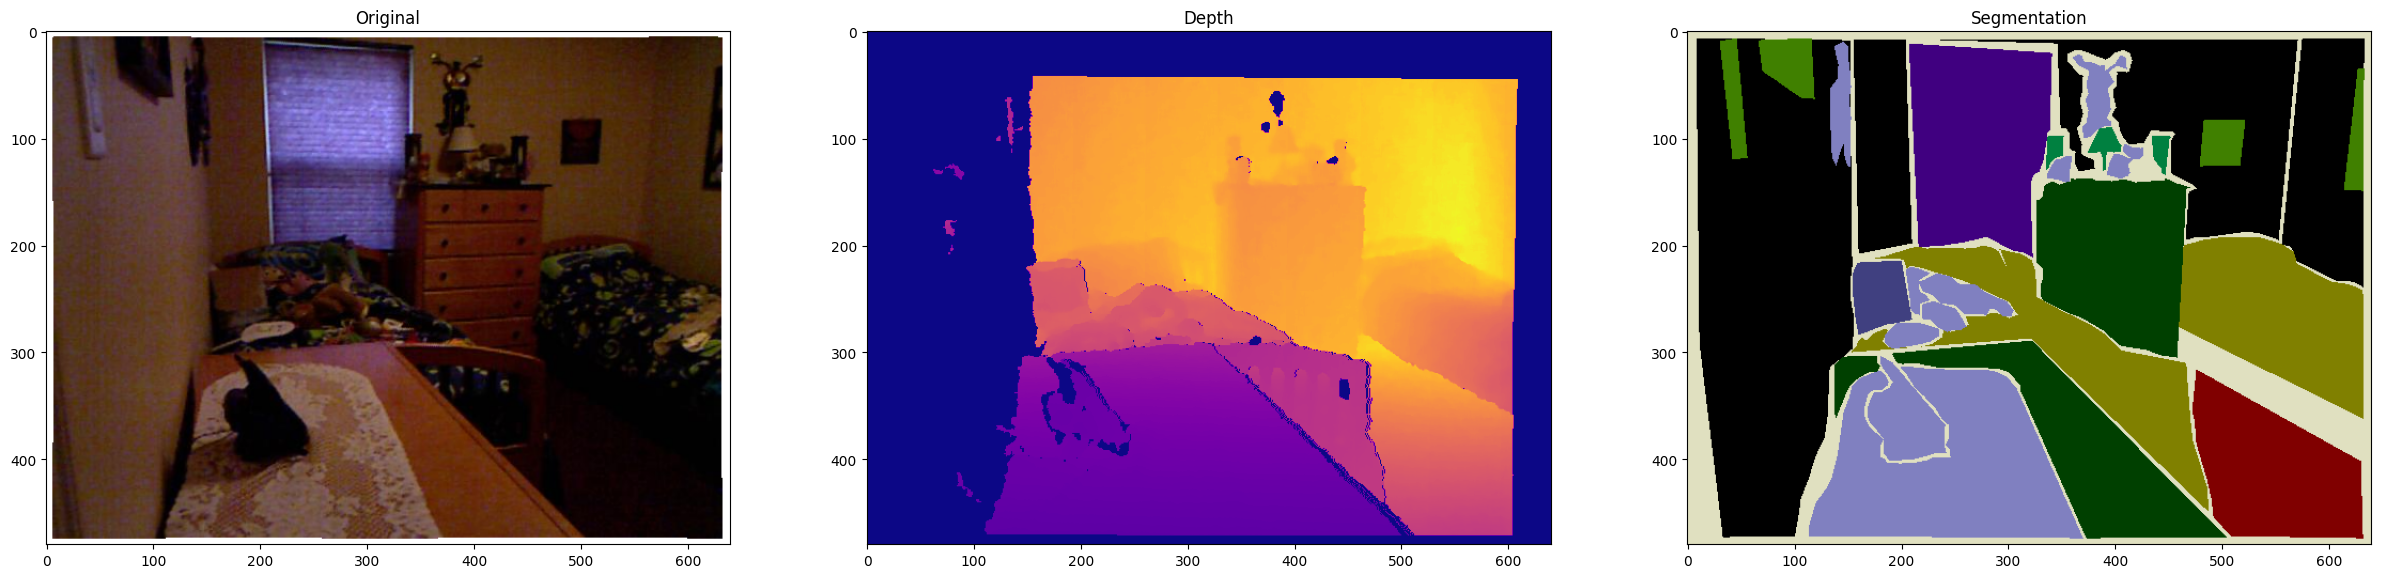

In [5]:
idx = np.random.randint(0,len(seg))

f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(30,90))
ax0.imshow(np.array(Image.open(images[idx])))
ax0.set_title("Original")
ax1.imshow(np.array(Image.open(depth[idx])), cmap="plasma")
ax1.set_title("Depth")
ax2.imshow(CMAP[np.array(Image.open(seg[idx]))])
ax2.set_title("Segmentation")
plt.show()

In [6]:
print(np.unique(np.array(Image.open(seg[idx]))))
print(len(np.unique(np.array(Image.open(seg[idx])))))

[  0   1   3  10  12  16  28  34  39 255]
10


In [7]:
data_file = "train_list_depth.txt"
with open(data_file, "rb") as f:
    datalist = f.readlines()
datalist = [x.decode("utf-8").strip("\n").split("\t") for x in datalist]
root_dir = "/nyud"
masks_names = ("segm", "depth")

print(datalist[0])

['rgb/000003.png', 'masks/000003.png', 'depth/000003.png']


In [8]:
import os
abs_paths = [os.path.join("nyud", rpath) for rpath in datalist[0]]
abs_paths

['nyud\\rgb/000003.png', 'nyud\\masks/000003.png', 'nyud\\depth/000003.png']

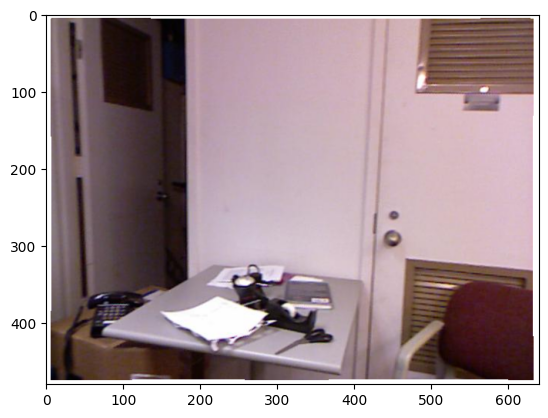

In [9]:
img_arr = np.array(Image.open(abs_paths[0]))

plt.imshow(img_arr)
plt.show()

segm
nyud\masks/000003.png


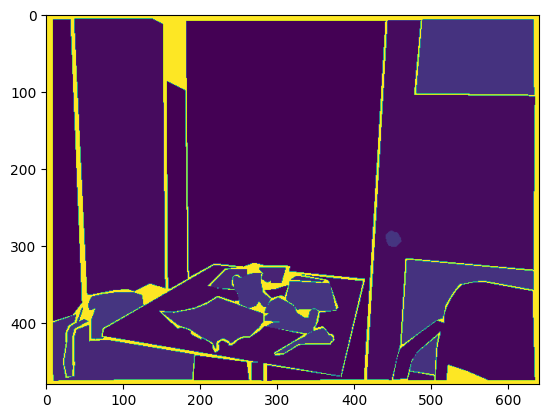

depth
nyud\depth/000003.png


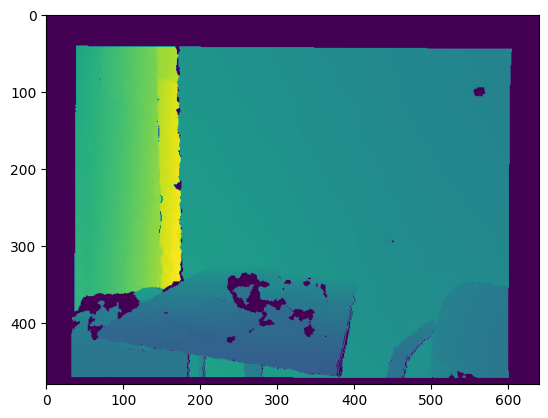

In [10]:
masks_names = ("segm", "depth")

for mask_name, mask_path in zip(masks_names, abs_paths[1:]):
    print(mask_name)
    print(mask_path)
    mask = np.array(Image.open(mask_path))
    plt.imshow(mask)
    plt.show()

In [11]:
from utils import Normalise, RandomCrop, ToTensor, RandomMirror
import torchvision.transforms as transforms

In [12]:
img_scale = 1.0 / 255
depth_scale = 5000.0

img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])

normalise_params = [img_scale, img_mean.reshape((1, 1, 3)), img_std.reshape((1, 1, 3)), depth_scale,]

transform_common = [Normalise(*normalise_params), ToTensor()]

In [13]:
crop_size = 400
transform_train = transforms.Compose([RandomMirror(), RandomCrop(crop_size)] + transform_common)
transform_val = transforms.Compose(transform_common)

In [14]:
train_batch_size = 8
val_batch_size = 4
train_file = "train_list_depth.txt"
val_file = "val_list_depth.txt"

In [15]:
from Dataset import NYUDv2Dataset
from torch.utils.data import DataLoader

#TRAIN DATALOADER
train_loader = DataLoader(
    NYUDv2Dataset(train_file, transform=transform_train,),
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True,
)

# VALIDATION DATALOADER
val_loader = DataLoader(
    NYUDv2Dataset(val_file, transform=transform_val,),
    batch_size=val_batch_size,
    shuffle=False, num_workers=4,
    pin_memory=True,
    drop_last=False,
)

In [16]:
from MobileNetV2 import MobileNetv2

encoder = MobileNetv2()
encoder.load_state_dict(torch.load("mobilenetv2-e6e8dd43.pth"))

<All keys matched successfully>

In [17]:
from LightweightRefineNet import LightWeightRefineNet

num_classes = (40, 1)
decoder = LightWeightRefineNet(encoder._out_c, num_classes)

## Training the Model

In [18]:
from utils import InvHuberLoss

ignore_index = 255
ignore_depth = 0

crit_segm = nn.CrossEntropyLoss(ignore_index=ignore_index).cuda()
crit_depth = InvHuberLoss(ignore_index=ignore_depth).cuda()

In [19]:
lr_encoder = 1e-2
lr_decoder = 1e-3
momentum_encoder = 0.9
momentum_decoder = 0.9
weight_decay_encoder = 1e-5
weight_decay_decoder = 1e-5

In [20]:
n_epochs = 1000

In [21]:
from model_helpers import Saver, load_state_dict
import operator
import json
import logging

init_vals = (0.0, 10000.0)
comp_fns = [operator.gt, operator.lt]
ckpt_dir = "./"
ckpt_path = "./checkpoint.pth.tar"

saver = Saver(
    args=locals(),
    ckpt_dir=ckpt_dir,
    best_val=init_vals,
    condition=comp_fns,
    save_several_mode=all,
)

In [22]:
optims = [torch.optim.SGD(encoder.parameters(), lr=lr_encoder,
                          momentum=momentum_encoder, weight_decay=weight_decay_encoder),
         torch.optim.SGD(decoder.parameters(), lr=lr_decoder,
                         momentum=momentum_decoder, weight_decay=weight_decay_decoder)
          ]

In [23]:
hydranet = nn.DataParallel(nn.Sequential(encoder, decoder).cuda()) # Use .cpu() if you prefer a slow death

print("Model has {} parameters".format(sum([p.numel() for p in hydranet.parameters()])))

start_epoch, _, state_dict = saver.maybe_load(ckpt_path=ckpt_path, keys_to_load=["epoch", "best_val", "state_dict"],)
load_state_dict(hydranet, state_dict)

if start_epoch is None:
    start_epoch = 0

Model has 3070057 parameters


In [24]:
opt_scheds = []
for opt in optims:
    opt_scheds.append(torch.optim.lr_scheduler.MultiStepLR(optimizer=opt,
                                                           milestones=np.arange(start_epoch + 1, n_epochs, 100),
                                                           gamma=0.1)
                      )

In [25]:
from utils import AverageMeter
from tqdm import tqdm

In [26]:
def train(model, opts, crits, dataloader, loss_coeffs=(1.0,), grad_norm=0.0):
    model.train()

    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
    loss_meter = AverageMeter()
    pbar = tqdm(dataloader)

    for sample in pbar:
        loss = 0.0
        input = sample["image"].float().to(device)
        targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]
        #[[sample["depth"].to(device), sample["segm"].to(device)]
        #input, targets = get_input_and_targets(sample=sample, dataloader=dataloader, device=device) # Get the data
        outputs = model(input) # Forward
        #outputs = list(outputs)

        for out, target, crit, loss_coeff in zip(outputs, targets, crits, loss_coeffs):
            loss += loss_coeff * crit(
                F.interpolate(
                    out, size=target.size()[1:], mode="bilinear", align_corners=False
                ).squeeze(dim=1),
                target.squeeze(dim=1),
            )

        # Backward
        for opt in opts:
            opt.zero_grad()
        loss.backward()
        if grad_norm > 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
        for opt in opts:
            opt.step()

        loss_meter.update(loss.item())
        pbar.set_description(
            "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
        )


In [27]:
def validate(model, metrics, dataloader):
    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
    model.eval()
    for metric in metrics:
        metric.reset()

    pbar = tqdm(dataloader)

    def get_val(metrics):
        results = [(m.name, m.val()) for m in metrics]
        names, vals = list(zip(*results))
        out = ["{} : {:4f}".format(name, val) for name, val in results]
        return vals, " | ".join(out)

    with torch.no_grad():
        for sample in pbar:
            # Get the Data
            input = sample["image"].float().to(device)
            targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]

            #input, targets = get_input_and_targets(sample=sample, dataloader=dataloader, device=device)
            targets = [target.squeeze(dim=1).cpu().numpy() for target in targets]

            # Forward
            outputs = model(input)
            #outputs = make_list(outputs)

            # Backward
            for out, target, metric in zip(outputs, targets, metrics):
                metric.update(
                    F.interpolate(out, size=target.shape[1:], mode="bilinear", align_corners=False)
                    .squeeze(dim=1)
                    .cpu()
                    .numpy(),
                    target,
                )
            pbar.set_description(get_val(metrics)[1])
    vals, _ = get_val(metrics)
    print("----" * 5)
    return vals

In [28]:
from utils import MeanIoU, RMSE

In [29]:
crop_size = 400
val_every = 5
loss_coeffs = (0.5, 0.5)

for i in range(start_epoch, n_epochs):

    print("Epoch {:d}".format(i))
    train(hydranet, optims, [crit_segm, crit_depth], train_loader, loss_coeffs)

    for sched in opt_scheds:
        sched.step()

    if i % val_every == 0:
        metrics = [MeanIoU(num_classes[0]),RMSE(ignore_val=ignore_depth),]

        with torch.no_grad():
            vals = validate(hydranet, metrics, val_loader)
        saver.maybe_save(new_val=vals, dict_to_save={"state_dict": hydranet.state_dict(), "epoch": i})

Epoch 0


Loss 1.891 | Avg. Loss 2.439: 100%|██████████| 99/99 [00:53<00:00,  1.84it/s]
meaniou : 0.012960 | rmse : 1.192507: 100%|██████████| 164/164 [02:43<00:00,  1.01it/s]


--------------------
Epoch 1


Loss 1.612 | Avg. Loss 1.787: 100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


Epoch 2


Loss 1.723 | Avg. Loss 1.863: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 3


Loss 1.651 | Avg. Loss 1.775: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 4


Loss 1.733 | Avg. Loss 1.724: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 5


Loss 1.686 | Avg. Loss 1.800: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]
meaniou : 0.017397 | rmse : 1.103415: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 6


Loss 1.550 | Avg. Loss 1.757: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 7


Loss 1.789 | Avg. Loss 1.738: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 8


Loss 1.782 | Avg. Loss 1.711: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 9


Loss 1.628 | Avg. Loss 1.703: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 10


Loss 1.789 | Avg. Loss 1.747: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]
meaniou : 0.020792 | rmse : 1.051087: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 11


Loss 1.581 | Avg. Loss 1.719: 100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


Epoch 12


Loss 1.504 | Avg. Loss 1.643: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 13


Loss 1.835 | Avg. Loss 1.672: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 14


Loss 1.652 | Avg. Loss 1.651: 100%|██████████| 99/99 [00:50<00:00,  1.96it/s]


Epoch 15


Loss 1.554 | Avg. Loss 1.642: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]
meaniou : 0.024558 | rmse : 0.992747: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 16


Loss 1.474 | Avg. Loss 1.696: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 17


Loss 1.770 | Avg. Loss 1.577: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 18


Loss 1.566 | Avg. Loss 1.692: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 19


Loss 1.603 | Avg. Loss 1.567: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 20


Loss 1.490 | Avg. Loss 1.663: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]
meaniou : 0.031945 | rmse : 0.951892: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 21


Loss 1.805 | Avg. Loss 1.568: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 22


Loss 1.506 | Avg. Loss 1.578: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 23


Loss 1.714 | Avg. Loss 1.464: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 24


Loss 1.689 | Avg. Loss 1.574: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 25


Loss 1.555 | Avg. Loss 1.472: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.038156 | rmse : 0.911421: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 26


Loss 1.376 | Avg. Loss 1.564: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 27


Loss 1.796 | Avg. Loss 1.448: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 28


Loss 1.416 | Avg. Loss 1.562: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 29


Loss 1.526 | Avg. Loss 1.483: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 30


Loss 1.425 | Avg. Loss 1.483: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]
meaniou : 0.040949 | rmse : 0.884921: 100%|██████████| 164/164 [02:52<00:00,  1.05s/it]


--------------------
Epoch 31


Loss 1.382 | Avg. Loss 1.497: 100%|██████████| 99/99 [00:50<00:00,  1.97it/s]


Epoch 32


Loss 1.528 | Avg. Loss 1.413: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 33


Loss 1.260 | Avg. Loss 1.400: 100%|██████████| 99/99 [00:50<00:00,  1.96it/s]


Epoch 34


Loss 1.502 | Avg. Loss 1.477: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 35


Loss 1.631 | Avg. Loss 1.430: 100%|██████████| 99/99 [00:50<00:00,  1.98it/s]
meaniou : 0.043876 | rmse : 0.871585: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


--------------------
Epoch 36


Loss 1.349 | Avg. Loss 1.389: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 37


Loss 1.507 | Avg. Loss 1.442: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 38


Loss 1.449 | Avg. Loss 1.413: 100%|██████████| 99/99 [00:49<00:00,  1.99it/s]


Epoch 39


Loss 1.540 | Avg. Loss 1.415: 100%|██████████| 99/99 [00:50<00:00,  1.96it/s]


Epoch 40


Loss 1.518 | Avg. Loss 1.441: 100%|██████████| 99/99 [00:53<00:00,  1.84it/s]
meaniou : 0.048578 | rmse : 0.841012: 100%|██████████| 164/164 [03:00<00:00,  1.10s/it]


--------------------
Epoch 41


Loss 1.484 | Avg. Loss 1.301: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 42


Loss 1.237 | Avg. Loss 1.411: 100%|██████████| 99/99 [00:50<00:00,  1.98it/s]


Epoch 43


Loss 1.197 | Avg. Loss 1.385: 100%|██████████| 99/99 [00:49<00:00,  1.99it/s]


Epoch 44


Loss 1.336 | Avg. Loss 1.356: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 45


Loss 1.220 | Avg. Loss 1.371: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]
meaniou : 0.055333 | rmse : 0.847762: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


--------------------
Epoch 46


Loss 1.391 | Avg. Loss 1.443: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 47


Loss 1.367 | Avg. Loss 1.349: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 48


Loss 1.332 | Avg. Loss 1.385: 100%|██████████| 99/99 [00:51<00:00,  1.92it/s]


Epoch 49


Loss 1.531 | Avg. Loss 1.333: 100%|██████████| 99/99 [00:51<00:00,  1.93it/s]


Epoch 50


Loss 1.317 | Avg. Loss 1.378: 100%|██████████| 99/99 [00:51<00:00,  1.91it/s]
meaniou : 0.055919 | rmse : 0.845883: 100%|██████████| 164/164 [03:09<00:00,  1.15s/it]


--------------------
Epoch 51


Loss 1.457 | Avg. Loss 1.339: 100%|██████████| 99/99 [01:02<00:00,  1.57it/s]


Epoch 52


Loss 1.533 | Avg. Loss 1.355: 100%|██████████| 99/99 [00:57<00:00,  1.73it/s]


Epoch 53


Loss 1.382 | Avg. Loss 1.327: 100%|██████████| 99/99 [00:59<00:00,  1.67it/s]


Epoch 54


Loss 1.271 | Avg. Loss 1.337: 100%|██████████| 99/99 [01:01<00:00,  1.61it/s]


Epoch 55


Loss 1.297 | Avg. Loss 1.333: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
meaniou : 0.061009 | rmse : 0.800146: 100%|██████████| 164/164 [03:39<00:00,  1.34s/it]


--------------------
Epoch 56


Loss 1.349 | Avg. Loss 1.309: 100%|██████████| 99/99 [01:20<00:00,  1.22it/s]


Epoch 57


Loss 1.291 | Avg. Loss 1.316: 100%|██████████| 99/99 [00:59<00:00,  1.66it/s]


Epoch 58


Loss 1.210 | Avg. Loss 1.314: 100%|██████████| 99/99 [00:57<00:00,  1.72it/s]


Epoch 59


Loss 1.284 | Avg. Loss 1.240: 100%|██████████| 99/99 [01:32<00:00,  1.07it/s]


Epoch 60


Loss 1.432 | Avg. Loss 1.281: 100%|██████████| 99/99 [01:15<00:00,  1.32it/s]
meaniou : 0.063824 | rmse : 0.794344: 100%|██████████| 164/164 [02:54<00:00,  1.06s/it]


--------------------
Epoch 61


Loss 1.282 | Avg. Loss 1.307: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 62


Loss 1.239 | Avg. Loss 1.268: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 63


Loss 1.379 | Avg. Loss 1.263: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 64


Loss 1.158 | Avg. Loss 1.233: 100%|██████████| 99/99 [00:52<00:00,  1.89it/s]


Epoch 65


Loss 1.422 | Avg. Loss 1.275: 100%|██████████| 99/99 [01:07<00:00,  1.46it/s]
meaniou : 0.065700 | rmse : 0.809978: 100%|██████████| 164/164 [03:20<00:00,  1.22s/it]


--------------------
Epoch 66


Loss 1.581 | Avg. Loss 1.209: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 67


Loss 1.062 | Avg. Loss 1.256: 100%|██████████| 99/99 [01:29<00:00,  1.10it/s]


Epoch 68


Loss 1.233 | Avg. Loss 1.326: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Epoch 69


Loss 1.358 | Avg. Loss 1.191: 100%|██████████| 99/99 [01:59<00:00,  1.21s/it]


Epoch 70


Loss 1.502 | Avg. Loss 1.310: 100%|██████████| 99/99 [01:30<00:00,  1.10it/s]
meaniou : 0.071241 | rmse : 0.793491: 100%|██████████| 164/164 [03:31<00:00,  1.29s/it]


--------------------
Epoch 71


Loss 0.978 | Avg. Loss 1.268: 100%|██████████| 99/99 [01:53<00:00,  1.15s/it]


Epoch 72


Loss 1.337 | Avg. Loss 1.232: 100%|██████████| 99/99 [00:50<00:00,  1.96it/s]


Epoch 73


Loss 1.228 | Avg. Loss 1.157: 100%|██████████| 99/99 [00:50<00:00,  1.97it/s]


Epoch 74


Loss 1.134 | Avg. Loss 1.221: 100%|██████████| 99/99 [00:50<00:00,  1.95it/s]


Epoch 75


Loss 1.213 | Avg. Loss 1.163: 100%|██████████| 99/99 [00:51<00:00,  1.94it/s]
meaniou : 0.075311 | rmse : 0.776223: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 76


Loss 1.347 | Avg. Loss 1.200: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 77


Loss 1.202 | Avg. Loss 1.301: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 78


Loss 1.188 | Avg. Loss 1.166: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 79


Loss 1.145 | Avg. Loss 1.303: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 80


Loss 1.040 | Avg. Loss 1.248: 100%|██████████| 99/99 [00:50<00:00,  1.98it/s]
meaniou : 0.081938 | rmse : 0.787504: 100%|██████████| 164/164 [02:46<00:00,  1.02s/it]


--------------------
Epoch 81


Loss 1.018 | Avg. Loss 1.136: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 82


Loss 1.111 | Avg. Loss 1.155: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 83


Loss 1.191 | Avg. Loss 1.273: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 84


Loss 1.219 | Avg. Loss 1.204: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 85


Loss 1.115 | Avg. Loss 1.232: 100%|██████████| 99/99 [00:50<00:00,  1.97it/s]
meaniou : 0.082553 | rmse : 0.770216: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 86


Loss 1.150 | Avg. Loss 1.213: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 87


Loss 1.440 | Avg. Loss 1.099: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 88


Loss 1.305 | Avg. Loss 1.130: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 89


Loss 1.170 | Avg. Loss 1.111: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 90


Loss 1.049 | Avg. Loss 1.172: 100%|██████████| 99/99 [00:49<00:00,  1.99it/s]
meaniou : 0.087315 | rmse : 0.767414: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 91


Loss 1.107 | Avg. Loss 1.114: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 92


Loss 1.053 | Avg. Loss 1.177: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 93


Loss 1.000 | Avg. Loss 1.101: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 94


Loss 1.127 | Avg. Loss 1.088: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 95


Loss 1.014 | Avg. Loss 1.154: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.090121 | rmse : 0.750772: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 96


Loss 1.092 | Avg. Loss 1.130: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 97


Loss 0.949 | Avg. Loss 1.133: 100%|██████████| 99/99 [00:50<00:00,  1.96it/s]


Epoch 98


Loss 1.057 | Avg. Loss 1.127: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 99


Loss 1.107 | Avg. Loss 1.077: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 100


Loss 1.018 | Avg. Loss 1.087: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]
meaniou : 0.093724 | rmse : 0.755584: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 101


Loss 1.274 | Avg. Loss 1.116: 100%|██████████| 99/99 [00:49<00:00,  1.99it/s]


Epoch 102


Loss 1.254 | Avg. Loss 1.022: 100%|██████████| 99/99 [00:50<00:00,  1.97it/s]


Epoch 103


Loss 1.056 | Avg. Loss 1.095: 100%|██████████| 99/99 [00:50<00:00,  1.97it/s]


Epoch 104


Loss 1.235 | Avg. Loss 1.064: 100%|██████████| 99/99 [00:49<00:00,  1.99it/s]


Epoch 105


Loss 1.020 | Avg. Loss 1.093: 100%|██████████| 99/99 [00:50<00:00,  1.97it/s]
meaniou : 0.094874 | rmse : 0.753855: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


--------------------
Epoch 106


Loss 1.216 | Avg. Loss 1.091: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 107


Loss 0.981 | Avg. Loss 1.023: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 108


Loss 0.974 | Avg. Loss 1.087: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 109


Loss 1.051 | Avg. Loss 1.091: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 110


Loss 1.157 | Avg. Loss 1.074: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]
meaniou : 0.095513 | rmse : 0.750553: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 111


Loss 1.098 | Avg. Loss 1.080: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 112


Loss 1.083 | Avg. Loss 1.116: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 113


Loss 1.087 | Avg. Loss 1.134: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 114


Loss 1.253 | Avg. Loss 1.149: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 115


Loss 1.206 | Avg. Loss 1.105: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]
meaniou : 0.095017 | rmse : 0.763720: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 116


Loss 1.134 | Avg. Loss 1.187: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 117


Loss 1.055 | Avg. Loss 1.114: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 118


Loss 1.156 | Avg. Loss 1.072: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 119


Loss 0.977 | Avg. Loss 1.095: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 120


Loss 1.093 | Avg. Loss 1.091: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]
meaniou : 0.096174 | rmse : 0.745289: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 121


Loss 1.115 | Avg. Loss 1.133: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 122


Loss 1.327 | Avg. Loss 1.059: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 123


Loss 1.087 | Avg. Loss 1.096: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 124


Loss 1.148 | Avg. Loss 1.086: 100%|██████████| 99/99 [00:51<00:00,  1.93it/s]


Epoch 125


Loss 1.045 | Avg. Loss 1.080: 100%|██████████| 99/99 [00:49<00:00,  1.99it/s]
meaniou : 0.096947 | rmse : 0.756901: 100%|██████████| 164/164 [02:48<00:00,  1.02s/it]


--------------------
Epoch 126


Loss 1.323 | Avg. Loss 1.146: 100%|██████████| 99/99 [00:51<00:00,  1.91it/s]


Epoch 127


Loss 0.916 | Avg. Loss 1.074: 100%|██████████| 99/99 [00:50<00:00,  1.97it/s]


Epoch 128


Loss 1.095 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 129


Loss 0.976 | Avg. Loss 1.122: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 130


Loss 1.126 | Avg. Loss 1.044: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.096398 | rmse : 0.757006: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 131


Loss 0.881 | Avg. Loss 1.114: 100%|██████████| 99/99 [00:51<00:00,  1.91it/s]


Epoch 132


Loss 1.064 | Avg. Loss 1.153: 100%|██████████| 99/99 [00:53<00:00,  1.86it/s]


Epoch 133


Loss 1.082 | Avg. Loss 1.108: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 134


Loss 1.019 | Avg. Loss 1.066: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 135


Loss 1.011 | Avg. Loss 1.106: 100%|██████████| 99/99 [01:04<00:00,  1.52it/s]
meaniou : 0.097069 | rmse : 0.750700: 100%|██████████| 164/164 [02:56<00:00,  1.08s/it]


--------------------
Epoch 136


Loss 1.166 | Avg. Loss 1.085: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 137


Loss 1.161 | Avg. Loss 1.050: 100%|██████████| 99/99 [01:04<00:00,  1.55it/s]


Epoch 138


Loss 1.146 | Avg. Loss 1.139: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 139


Loss 1.320 | Avg. Loss 1.109: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 140


Loss 1.063 | Avg. Loss 1.094: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]
meaniou : 0.098411 | rmse : 0.752409: 100%|██████████| 164/164 [02:58<00:00,  1.09s/it]


--------------------
Epoch 141


Loss 1.025 | Avg. Loss 1.089: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 142


Loss 1.055 | Avg. Loss 1.035: 100%|██████████| 99/99 [01:02<00:00,  1.57it/s]


Epoch 143


Loss 0.977 | Avg. Loss 1.091: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 144


Loss 1.183 | Avg. Loss 1.100: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 145


Loss 1.208 | Avg. Loss 1.076: 100%|██████████| 99/99 [01:05<00:00,  1.51it/s]
meaniou : 0.097678 | rmse : 0.752909: 100%|██████████| 164/164 [03:00<00:00,  1.10s/it]


--------------------
Epoch 146


Loss 1.196 | Avg. Loss 1.079: 100%|██████████| 99/99 [01:06<00:00,  1.48it/s]


Epoch 147


Loss 1.197 | Avg. Loss 1.086: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]


Epoch 148


Loss 1.207 | Avg. Loss 1.083: 100%|██████████| 99/99 [01:08<00:00,  1.45it/s]


Epoch 149


Loss 1.123 | Avg. Loss 1.087: 100%|██████████| 99/99 [01:08<00:00,  1.45it/s]


Epoch 150


Loss 1.026 | Avg. Loss 1.080: 100%|██████████| 99/99 [01:06<00:00,  1.49it/s]
meaniou : 0.099067 | rmse : 0.750447: 100%|██████████| 164/164 [03:04<00:00,  1.13s/it]


--------------------
Epoch 151


Loss 1.145 | Avg. Loss 1.045: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 152


Loss 0.873 | Avg. Loss 1.175: 100%|██████████| 99/99 [00:59<00:00,  1.66it/s]


Epoch 153


Loss 1.126 | Avg. Loss 1.045: 100%|██████████| 99/99 [01:00<00:00,  1.64it/s]


Epoch 154


Loss 1.007 | Avg. Loss 1.055: 100%|██████████| 99/99 [01:06<00:00,  1.50it/s]


Epoch 155


Loss 1.030 | Avg. Loss 1.187: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
meaniou : 0.098901 | rmse : 0.754152: 100%|██████████| 164/164 [02:59<00:00,  1.09s/it]


--------------------
Epoch 156


Loss 1.270 | Avg. Loss 1.059: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 157


Loss 1.022 | Avg. Loss 1.127: 100%|██████████| 99/99 [01:05<00:00,  1.51it/s]


Epoch 158


Loss 1.007 | Avg. Loss 1.104: 100%|██████████| 99/99 [01:04<00:00,  1.53it/s]


Epoch 159


Loss 1.146 | Avg. Loss 1.052: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 160


Loss 1.203 | Avg. Loss 1.062: 100%|██████████| 99/99 [01:06<00:00,  1.49it/s]
meaniou : 0.098786 | rmse : 0.754548: 100%|██████████| 164/164 [03:05<00:00,  1.13s/it]


--------------------
Epoch 161


Loss 1.026 | Avg. Loss 1.119: 100%|██████████| 99/99 [01:12<00:00,  1.36it/s]


Epoch 162


Loss 1.074 | Avg. Loss 1.094: 100%|██████████| 99/99 [01:24<00:00,  1.18it/s]


Epoch 163


Loss 1.066 | Avg. Loss 1.062: 100%|██████████| 99/99 [01:12<00:00,  1.36it/s]


Epoch 164


Loss 0.916 | Avg. Loss 1.084: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 165


Loss 0.979 | Avg. Loss 1.063: 100%|██████████| 99/99 [01:01<00:00,  1.61it/s]
meaniou : 0.100366 | rmse : 0.754141: 100%|██████████| 164/164 [02:58<00:00,  1.09s/it]


--------------------
Epoch 166


Loss 1.130 | Avg. Loss 1.041: 100%|██████████| 99/99 [01:02<00:00,  1.57it/s]


Epoch 167


Loss 1.313 | Avg. Loss 1.076: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 168


Loss 0.932 | Avg. Loss 1.076: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 169


Loss 0.979 | Avg. Loss 1.065: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 170


Loss 1.153 | Avg. Loss 1.099: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]
meaniou : 0.101020 | rmse : 0.753690: 100%|██████████| 164/164 [02:57<00:00,  1.08s/it]


--------------------
Epoch 171


Loss 1.002 | Avg. Loss 1.051: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 172


Loss 1.079 | Avg. Loss 1.076: 100%|██████████| 99/99 [01:04<00:00,  1.53it/s]


Epoch 173


Loss 1.296 | Avg. Loss 1.010: 100%|██████████| 99/99 [01:04<00:00,  1.55it/s]


Epoch 174


Loss 1.154 | Avg. Loss 1.075: 100%|██████████| 99/99 [01:04<00:00,  1.53it/s]


Epoch 175


Loss 1.082 | Avg. Loss 1.093: 100%|██████████| 99/99 [01:04<00:00,  1.53it/s]
meaniou : 0.100688 | rmse : 0.749607: 100%|██████████| 164/164 [02:58<00:00,  1.09s/it]


--------------------
Epoch 176


Loss 1.074 | Avg. Loss 1.060: 100%|██████████| 99/99 [01:03<00:00,  1.57it/s]


Epoch 177


Loss 0.905 | Avg. Loss 1.068: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 178


Loss 1.002 | Avg. Loss 1.036: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 179


Loss 1.146 | Avg. Loss 1.024: 100%|██████████| 99/99 [01:04<00:00,  1.53it/s]


Epoch 180


Loss 0.966 | Avg. Loss 1.061: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]
meaniou : 0.101575 | rmse : 0.747510: 100%|██████████| 164/164 [02:57<00:00,  1.08s/it]


--------------------
Epoch 181


Loss 0.892 | Avg. Loss 1.050: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 182


Loss 1.116 | Avg. Loss 1.103: 100%|██████████| 99/99 [01:04<00:00,  1.52it/s]


Epoch 183


Loss 1.297 | Avg. Loss 1.067: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 184


Loss 0.900 | Avg. Loss 1.057: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 185


Loss 1.042 | Avg. Loss 1.076: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]
meaniou : 0.101921 | rmse : 0.747021: 100%|██████████| 164/164 [03:00<00:00,  1.10s/it]


--------------------
Epoch 186


Loss 1.098 | Avg. Loss 1.167: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 187


Loss 0.857 | Avg. Loss 1.079: 100%|██████████| 99/99 [01:04<00:00,  1.53it/s]


Epoch 188


Loss 1.056 | Avg. Loss 1.088: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]


Epoch 189


Loss 0.987 | Avg. Loss 1.026: 100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


Epoch 190


Loss 0.947 | Avg. Loss 1.074: 100%|██████████| 99/99 [00:54<00:00,  1.81it/s]
meaniou : 0.101815 | rmse : 0.743625: 100%|██████████| 164/164 [02:50<00:00,  1.04s/it]


--------------------
Epoch 191


Loss 1.044 | Avg. Loss 1.038: 100%|██████████| 99/99 [00:53<00:00,  1.84it/s]


Epoch 192


Loss 0.772 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:54<00:00,  1.82it/s]


Epoch 193


Loss 0.938 | Avg. Loss 0.998: 100%|██████████| 99/99 [00:54<00:00,  1.81it/s]


Epoch 194


Loss 0.816 | Avg. Loss 1.087: 100%|██████████| 99/99 [00:54<00:00,  1.81it/s]


Epoch 195


Loss 1.191 | Avg. Loss 1.089: 100%|██████████| 99/99 [00:54<00:00,  1.80it/s]
meaniou : 0.102557 | rmse : 0.748659: 100%|██████████| 164/164 [02:54<00:00,  1.06s/it]


--------------------
Epoch 196


Loss 1.004 | Avg. Loss 1.048: 100%|██████████| 99/99 [01:02<00:00,  1.58it/s]


Epoch 197


Loss 1.010 | Avg. Loss 1.111: 100%|██████████| 99/99 [00:57<00:00,  1.72it/s]


Epoch 198


Loss 1.093 | Avg. Loss 1.063: 100%|██████████| 99/99 [00:54<00:00,  1.83it/s]


Epoch 199


Loss 1.089 | Avg. Loss 1.055: 100%|██████████| 99/99 [00:54<00:00,  1.83it/s]


Epoch 200


Loss 1.174 | Avg. Loss 1.058: 100%|██████████| 99/99 [00:54<00:00,  1.83it/s]
meaniou : 0.103594 | rmse : 0.751664: 100%|██████████| 164/164 [02:53<00:00,  1.06s/it]


--------------------
Epoch 201


Loss 1.232 | Avg. Loss 1.024: 100%|██████████| 99/99 [00:54<00:00,  1.82it/s]


Epoch 202


Loss 0.956 | Avg. Loss 1.028: 100%|██████████| 99/99 [00:54<00:00,  1.80it/s]


Epoch 203


Loss 1.303 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:53<00:00,  1.84it/s]


Epoch 204


Loss 1.137 | Avg. Loss 1.081: 100%|██████████| 99/99 [00:54<00:00,  1.83it/s]


Epoch 205


Loss 1.137 | Avg. Loss 1.077: 100%|██████████| 99/99 [00:54<00:00,  1.83it/s]
meaniou : 0.103298 | rmse : 0.746847: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 206


Loss 0.928 | Avg. Loss 1.091: 100%|██████████| 99/99 [00:53<00:00,  1.87it/s]


Epoch 207


Loss 1.027 | Avg. Loss 1.064: 100%|██████████| 99/99 [00:54<00:00,  1.82it/s]


Epoch 208


Loss 1.213 | Avg. Loss 0.985: 100%|██████████| 99/99 [00:54<00:00,  1.83it/s]


Epoch 209


Loss 1.144 | Avg. Loss 1.017: 100%|██████████| 99/99 [00:54<00:00,  1.83it/s]


Epoch 210


Loss 1.083 | Avg. Loss 1.095: 100%|██████████| 99/99 [00:54<00:00,  1.82it/s]
meaniou : 0.104338 | rmse : 0.745442: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 211


Loss 1.288 | Avg. Loss 1.016: 100%|██████████| 99/99 [01:00<00:00,  1.64it/s]


Epoch 212


Loss 1.158 | Avg. Loss 1.008: 100%|██████████| 99/99 [01:00<00:00,  1.62it/s]


Epoch 213


Loss 1.113 | Avg. Loss 1.066: 100%|██████████| 99/99 [01:04<00:00,  1.55it/s]


Epoch 214


Loss 1.062 | Avg. Loss 1.082: 100%|██████████| 99/99 [01:04<00:00,  1.53it/s]


Epoch 215


Loss 1.094 | Avg. Loss 1.034: 100%|██████████| 99/99 [01:04<00:00,  1.52it/s]
meaniou : 0.102767 | rmse : 0.750356: 100%|██████████| 164/164 [02:58<00:00,  1.09s/it]


--------------------
Epoch 216


Loss 0.982 | Avg. Loss 1.070: 100%|██████████| 99/99 [00:55<00:00,  1.80it/s]


Epoch 217


Loss 1.048 | Avg. Loss 1.053: 100%|██████████| 99/99 [00:55<00:00,  1.80it/s]


Epoch 218


Loss 1.174 | Avg. Loss 1.101: 100%|██████████| 99/99 [00:59<00:00,  1.66it/s]


Epoch 219


Loss 0.945 | Avg. Loss 1.092: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]


Epoch 220


Loss 1.114 | Avg. Loss 1.033: 100%|██████████| 99/99 [01:04<00:00,  1.53it/s]
meaniou : 0.103477 | rmse : 0.749076: 100%|██████████| 164/164 [02:58<00:00,  1.09s/it]


--------------------
Epoch 221


Loss 1.010 | Avg. Loss 1.062: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 222


Loss 1.114 | Avg. Loss 1.111: 100%|██████████| 99/99 [01:04<00:00,  1.53it/s]


Epoch 223


Loss 0.796 | Avg. Loss 1.049: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 224


Loss 1.186 | Avg. Loss 1.045: 100%|██████████| 99/99 [01:04<00:00,  1.53it/s]


Epoch 225


Loss 0.948 | Avg. Loss 1.105: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
meaniou : 0.102858 | rmse : 0.748412: 100%|██████████| 164/164 [02:59<00:00,  1.09s/it]


--------------------
Epoch 226


Loss 1.154 | Avg. Loss 1.063: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 227


Loss 1.093 | Avg. Loss 1.004: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]


Epoch 228


Loss 1.000 | Avg. Loss 1.035: 100%|██████████| 99/99 [01:04<00:00,  1.53it/s]


Epoch 229


Loss 1.023 | Avg. Loss 1.106: 100%|██████████| 99/99 [01:03<00:00,  1.57it/s]


Epoch 230


Loss 0.990 | Avg. Loss 1.139: 100%|██████████| 99/99 [00:56<00:00,  1.75it/s]
meaniou : 0.103164 | rmse : 0.745854: 100%|██████████| 164/164 [02:59<00:00,  1.09s/it]


--------------------
Epoch 231


Loss 1.060 | Avg. Loss 1.044: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 232


Loss 1.195 | Avg. Loss 1.082: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 233


Loss 1.064 | Avg. Loss 1.054: 100%|██████████| 99/99 [01:05<00:00,  1.51it/s]


Epoch 234


Loss 1.125 | Avg. Loss 0.992: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 235


Loss 1.338 | Avg. Loss 1.099: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]
meaniou : 0.103978 | rmse : 0.744244: 100%|██████████| 164/164 [02:56<00:00,  1.08s/it]


--------------------
Epoch 236


Loss 0.895 | Avg. Loss 1.054: 100%|██████████| 99/99 [01:02<00:00,  1.59it/s]


Epoch 237


Loss 0.938 | Avg. Loss 1.069: 100%|██████████| 99/99 [01:03<00:00,  1.57it/s]


Epoch 238


Loss 0.967 | Avg. Loss 1.088: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 239


Loss 1.029 | Avg. Loss 1.078: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 240


Loss 1.123 | Avg. Loss 1.041: 100%|██████████| 99/99 [01:04<00:00,  1.55it/s]
meaniou : 0.103857 | rmse : 0.745847: 100%|██████████| 164/164 [02:56<00:00,  1.07s/it]


--------------------
Epoch 241


Loss 1.009 | Avg. Loss 1.018: 100%|██████████| 99/99 [01:02<00:00,  1.58it/s]


Epoch 242


Loss 1.162 | Avg. Loss 1.056: 100%|██████████| 99/99 [00:56<00:00,  1.76it/s]


Epoch 243


Loss 1.036 | Avg. Loss 1.110: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 244


Loss 1.165 | Avg. Loss 1.020: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 245


Loss 1.207 | Avg. Loss 1.056: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.104364 | rmse : 0.748026: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 246


Loss 1.092 | Avg. Loss 1.058: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 247


Loss 1.092 | Avg. Loss 0.970: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 248


Loss 1.181 | Avg. Loss 1.030: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 249


Loss 1.066 | Avg. Loss 1.086: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 250


Loss 1.103 | Avg. Loss 1.041: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.103068 | rmse : 0.748087: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 251


Loss 1.046 | Avg. Loss 1.082: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 252


Loss 1.059 | Avg. Loss 1.126: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 253


Loss 1.288 | Avg. Loss 1.098: 100%|██████████| 99/99 [00:55<00:00,  1.78it/s]


Epoch 254


Loss 0.981 | Avg. Loss 1.112: 100%|██████████| 99/99 [01:01<00:00,  1.60it/s]


Epoch 255


Loss 1.061 | Avg. Loss 1.076: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]
meaniou : 0.102536 | rmse : 0.749356: 100%|██████████| 164/164 [02:56<00:00,  1.08s/it]


--------------------
Epoch 256


Loss 0.939 | Avg. Loss 1.061: 100%|██████████| 99/99 [01:02<00:00,  1.58it/s]


Epoch 257


Loss 1.037 | Avg. Loss 0.990: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 258


Loss 1.291 | Avg. Loss 1.034: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 259


Loss 1.067 | Avg. Loss 1.126: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 260


Loss 0.949 | Avg. Loss 1.060: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
meaniou : 0.104430 | rmse : 0.747774: 100%|██████████| 164/164 [02:55<00:00,  1.07s/it]


--------------------
Epoch 261


Loss 1.035 | Avg. Loss 1.035: 100%|██████████| 99/99 [01:02<00:00,  1.58it/s]


Epoch 262


Loss 1.139 | Avg. Loss 1.092: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 263


Loss 1.044 | Avg. Loss 1.095: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 264


Loss 1.033 | Avg. Loss 1.027: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 265


Loss 1.235 | Avg. Loss 1.102: 100%|██████████| 99/99 [01:04<00:00,  1.52it/s]
meaniou : 0.102546 | rmse : 0.744900: 100%|██████████| 164/164 [03:00<00:00,  1.10s/it]


--------------------
Epoch 266


Loss 0.916 | Avg. Loss 1.092: 100%|██████████| 99/99 [01:02<00:00,  1.59it/s]


Epoch 267


Loss 1.122 | Avg. Loss 1.079: 100%|██████████| 99/99 [01:03<00:00,  1.57it/s]


Epoch 268


Loss 1.333 | Avg. Loss 1.094: 100%|██████████| 99/99 [01:03<00:00,  1.57it/s]


Epoch 269


Loss 1.018 | Avg. Loss 1.056: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 270


Loss 1.038 | Avg. Loss 1.042: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]
meaniou : 0.103582 | rmse : 0.741366: 100%|██████████| 164/164 [02:56<00:00,  1.08s/it]


--------------------
Epoch 271


Loss 1.138 | Avg. Loss 1.028: 100%|██████████| 99/99 [01:02<00:00,  1.58it/s]


Epoch 272


Loss 1.110 | Avg. Loss 0.980: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 273


Loss 1.175 | Avg. Loss 1.082: 100%|██████████| 99/99 [01:06<00:00,  1.48it/s]


Epoch 274


Loss 1.173 | Avg. Loss 1.066: 100%|██████████| 99/99 [01:09<00:00,  1.42it/s]


Epoch 275


Loss 1.090 | Avg. Loss 1.070: 100%|██████████| 99/99 [01:10<00:00,  1.41it/s]
meaniou : 0.103080 | rmse : 0.744891: 100%|██████████| 164/164 [02:55<00:00,  1.07s/it]


--------------------
Epoch 276


Loss 0.886 | Avg. Loss 1.078: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 277


Loss 0.970 | Avg. Loss 1.047: 100%|██████████| 99/99 [00:49<00:00,  1.98it/s]


Epoch 278


Loss 0.942 | Avg. Loss 1.092: 100%|██████████| 99/99 [00:50<00:00,  1.97it/s]


Epoch 279


Loss 1.036 | Avg. Loss 1.068: 100%|██████████| 99/99 [00:50<00:00,  1.96it/s]


Epoch 280


Loss 1.261 | Avg. Loss 1.050: 100%|██████████| 99/99 [00:50<00:00,  1.96it/s]
meaniou : 0.104054 | rmse : 0.749644: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 281


Loss 0.919 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 282


Loss 0.977 | Avg. Loss 1.153: 100%|██████████| 99/99 [00:49<00:00,  1.99it/s]


Epoch 283


Loss 0.962 | Avg. Loss 1.048: 100%|██████████| 99/99 [00:50<00:00,  1.98it/s]


Epoch 284


Loss 0.909 | Avg. Loss 1.042: 100%|██████████| 99/99 [00:50<00:00,  1.96it/s]


Epoch 285


Loss 1.143 | Avg. Loss 1.008: 100%|██████████| 99/99 [00:50<00:00,  1.97it/s]
meaniou : 0.104410 | rmse : 0.743773: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 286


Loss 1.211 | Avg. Loss 1.024: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 287


Loss 0.891 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 288


Loss 1.083 | Avg. Loss 1.029: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 289


Loss 1.042 | Avg. Loss 0.981: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 290


Loss 1.045 | Avg. Loss 1.167: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]
meaniou : 0.103894 | rmse : 0.752917: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 291


Loss 0.993 | Avg. Loss 1.032: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 292


Loss 1.098 | Avg. Loss 1.037: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 293


Loss 1.101 | Avg. Loss 1.056: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 294


Loss 1.204 | Avg. Loss 1.015: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 295


Loss 1.011 | Avg. Loss 1.122: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.104975 | rmse : 0.744106: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 296


Loss 0.937 | Avg. Loss 1.107: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 297


Loss 1.064 | Avg. Loss 1.020: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 298


Loss 0.987 | Avg. Loss 1.022: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 299


Loss 0.962 | Avg. Loss 1.028: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 300


Loss 1.116 | Avg. Loss 1.067: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.104254 | rmse : 0.748385: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 301


Loss 1.240 | Avg. Loss 1.125: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 302


Loss 0.999 | Avg. Loss 1.041: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 303


Loss 0.932 | Avg. Loss 1.069: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 304


Loss 0.885 | Avg. Loss 1.062: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 305


Loss 0.964 | Avg. Loss 1.056: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.103800 | rmse : 0.741027: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 306


Loss 0.980 | Avg. Loss 1.032: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 307


Loss 1.212 | Avg. Loss 1.093: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 308


Loss 1.234 | Avg. Loss 0.982: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 309


Loss 1.016 | Avg. Loss 1.086: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 310


Loss 1.240 | Avg. Loss 1.038: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.104349 | rmse : 0.747526: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 311


Loss 0.958 | Avg. Loss 1.001: 100%|██████████| 99/99 [00:57<00:00,  1.72it/s]


Epoch 312


Loss 0.927 | Avg. Loss 1.148: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 313


Loss 0.965 | Avg. Loss 1.085: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 314


Loss 1.104 | Avg. Loss 1.076: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 315


Loss 1.016 | Avg. Loss 1.013: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.104084 | rmse : 0.753781: 100%|██████████| 164/164 [02:46<00:00,  1.01s/it]


--------------------
Epoch 316


Loss 1.207 | Avg. Loss 1.036: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 317


Loss 0.924 | Avg. Loss 1.028: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 318


Loss 0.885 | Avg. Loss 1.066: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 319


Loss 1.071 | Avg. Loss 1.070: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 320


Loss 1.036 | Avg. Loss 1.082: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]
meaniou : 0.104203 | rmse : 0.749600: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 321


Loss 1.011 | Avg. Loss 1.053: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 322


Loss 1.086 | Avg. Loss 1.105: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 323


Loss 1.192 | Avg. Loss 1.037: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 324


Loss 1.022 | Avg. Loss 1.015: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 325


Loss 1.205 | Avg. Loss 1.083: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.104893 | rmse : 0.744164: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 326


Loss 0.992 | Avg. Loss 1.079: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 327


Loss 1.117 | Avg. Loss 1.088: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 328


Loss 1.095 | Avg. Loss 1.063: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 329


Loss 1.092 | Avg. Loss 1.064: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 330


Loss 1.094 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.103779 | rmse : 0.744877: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 331


Loss 0.998 | Avg. Loss 1.123: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 332


Loss 1.184 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:50<00:00,  1.96it/s]


Epoch 333


Loss 0.970 | Avg. Loss 1.102: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 334


Loss 0.914 | Avg. Loss 1.042: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 335


Loss 1.080 | Avg. Loss 1.081: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.103957 | rmse : 0.744463: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 336


Loss 1.070 | Avg. Loss 1.087: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 337


Loss 1.148 | Avg. Loss 1.046: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 338


Loss 1.173 | Avg. Loss 1.036: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 339


Loss 1.095 | Avg. Loss 1.026: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 340


Loss 1.072 | Avg. Loss 1.014: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.104239 | rmse : 0.745628: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 341


Loss 1.207 | Avg. Loss 1.013: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 342


Loss 1.289 | Avg. Loss 1.010: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 343


Loss 1.055 | Avg. Loss 1.051: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 344


Loss 0.948 | Avg. Loss 1.062: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 345


Loss 1.047 | Avg. Loss 1.020: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.104675 | rmse : 0.742046: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 346


Loss 1.191 | Avg. Loss 1.040: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 347


Loss 1.048 | Avg. Loss 1.064: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 348


Loss 1.060 | Avg. Loss 1.010: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 349


Loss 1.088 | Avg. Loss 1.023: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 350


Loss 1.009 | Avg. Loss 1.014: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.104206 | rmse : 0.754895: 100%|██████████| 164/164 [02:43<00:00,  1.01it/s]


--------------------
Epoch 351


Loss 1.126 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 352


Loss 0.986 | Avg. Loss 1.039: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 353


Loss 1.161 | Avg. Loss 1.021: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 354


Loss 1.003 | Avg. Loss 1.022: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 355


Loss 1.253 | Avg. Loss 0.995: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.104574 | rmse : 0.753634: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 356


Loss 0.952 | Avg. Loss 1.097: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 357


Loss 1.137 | Avg. Loss 1.053: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 358


Loss 1.312 | Avg. Loss 1.012: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 359


Loss 1.184 | Avg. Loss 1.136: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 360


Loss 1.165 | Avg. Loss 1.141: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]
meaniou : 0.104799 | rmse : 0.745627: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 361


Loss 0.942 | Avg. Loss 1.003: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 362


Loss 1.046 | Avg. Loss 1.028: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 363


Loss 1.184 | Avg. Loss 0.956: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 364


Loss 1.027 | Avg. Loss 1.071: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 365


Loss 0.870 | Avg. Loss 0.986: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.103404 | rmse : 0.747870: 100%|██████████| 164/164 [02:43<00:00,  1.01it/s]


--------------------
Epoch 366


Loss 0.971 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 367


Loss 1.095 | Avg. Loss 1.045: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 368


Loss 1.202 | Avg. Loss 1.050: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 369


Loss 0.982 | Avg. Loss 1.014: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 370


Loss 1.027 | Avg. Loss 1.028: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]
meaniou : 0.104165 | rmse : 0.745232: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 371


Loss 0.967 | Avg. Loss 1.064: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 372


Loss 0.972 | Avg. Loss 1.088: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 373


Loss 0.834 | Avg. Loss 1.092: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 374


Loss 1.045 | Avg. Loss 1.052: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 375


Loss 1.031 | Avg. Loss 1.116: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.105344 | rmse : 0.748260: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 376


Loss 1.075 | Avg. Loss 1.033: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 377


Loss 0.904 | Avg. Loss 0.964: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 378


Loss 1.036 | Avg. Loss 1.081: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 379


Loss 1.085 | Avg. Loss 1.047: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 380


Loss 0.934 | Avg. Loss 1.108: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.104124 | rmse : 0.753407: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 381


Loss 1.029 | Avg. Loss 0.987: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 382


Loss 1.273 | Avg. Loss 1.038: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 383


Loss 0.910 | Avg. Loss 0.977: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 384


Loss 0.899 | Avg. Loss 1.027: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 385


Loss 0.899 | Avg. Loss 1.036: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.104468 | rmse : 0.747759: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 386


Loss 0.961 | Avg. Loss 1.049: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 387


Loss 1.103 | Avg. Loss 1.043: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 388


Loss 1.202 | Avg. Loss 1.033: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 389


Loss 1.040 | Avg. Loss 1.017: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 390


Loss 1.077 | Avg. Loss 1.074: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.103512 | rmse : 0.744080: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 391


Loss 0.998 | Avg. Loss 1.076: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 392


Loss 1.102 | Avg. Loss 0.975: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 393


Loss 0.972 | Avg. Loss 1.026: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 394


Loss 1.118 | Avg. Loss 1.020: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 395


Loss 0.971 | Avg. Loss 1.017: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]
meaniou : 0.104915 | rmse : 0.744126: 100%|██████████| 164/164 [02:46<00:00,  1.02s/it]


--------------------
Epoch 396


Loss 1.062 | Avg. Loss 1.097: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 397


Loss 1.086 | Avg. Loss 1.069: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 398


Loss 1.124 | Avg. Loss 1.032: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 399


Loss 1.213 | Avg. Loss 0.996: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 400


Loss 0.928 | Avg. Loss 1.135: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.104549 | rmse : 0.745900: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 401


Loss 1.262 | Avg. Loss 1.095: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 402


Loss 1.002 | Avg. Loss 0.978: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 403


Loss 1.093 | Avg. Loss 1.030: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 404


Loss 1.043 | Avg. Loss 1.033: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 405


Loss 0.899 | Avg. Loss 1.042: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.104450 | rmse : 0.742999: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 406


Loss 1.035 | Avg. Loss 1.026: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 407


Loss 1.112 | Avg. Loss 1.045: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 408


Loss 0.930 | Avg. Loss 1.063: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 409


Loss 1.092 | Avg. Loss 1.122: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 410


Loss 1.264 | Avg. Loss 1.097: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.103321 | rmse : 0.757936: 100%|██████████| 164/164 [02:44<00:00,  1.01s/it]


--------------------
Epoch 411


Loss 1.045 | Avg. Loss 1.086: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 412


Loss 1.327 | Avg. Loss 1.078: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 413


Loss 1.068 | Avg. Loss 1.082: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 414


Loss 1.312 | Avg. Loss 0.972: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 415


Loss 1.248 | Avg. Loss 0.984: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]
meaniou : 0.105677 | rmse : 0.746244: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 416


Loss 1.160 | Avg. Loss 1.042: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 417


Loss 1.028 | Avg. Loss 1.123: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 418


Loss 1.042 | Avg. Loss 0.986: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 419


Loss 0.998 | Avg. Loss 1.123: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 420


Loss 0.998 | Avg. Loss 1.148: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]
meaniou : 0.104423 | rmse : 0.747873: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 421


Loss 0.907 | Avg. Loss 1.170: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 422


Loss 0.955 | Avg. Loss 1.085: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 423


Loss 1.164 | Avg. Loss 1.053: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 424


Loss 1.065 | Avg. Loss 1.041: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 425


Loss 1.112 | Avg. Loss 1.039: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.103427 | rmse : 0.743447: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 426


Loss 0.894 | Avg. Loss 1.030: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 427


Loss 1.179 | Avg. Loss 1.014: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 428


Loss 1.160 | Avg. Loss 1.088: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 429


Loss 1.090 | Avg. Loss 1.041: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 430


Loss 1.039 | Avg. Loss 1.038: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.104776 | rmse : 0.758536: 100%|██████████| 164/164 [02:46<00:00,  1.01s/it]


--------------------
Epoch 431


Loss 1.052 | Avg. Loss 1.095: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 432


Loss 0.987 | Avg. Loss 1.069: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 433


Loss 1.217 | Avg. Loss 1.042: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 434


Loss 1.234 | Avg. Loss 1.021: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 435


Loss 1.071 | Avg. Loss 1.111: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]
meaniou : 0.105095 | rmse : 0.754439: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 436


Loss 0.938 | Avg. Loss 1.047: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 437


Loss 0.952 | Avg. Loss 1.019: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 438


Loss 0.953 | Avg. Loss 1.127: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 439


Loss 1.099 | Avg. Loss 1.083: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 440


Loss 1.085 | Avg. Loss 1.055: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]
meaniou : 0.104338 | rmse : 0.743328: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 441


Loss 0.974 | Avg. Loss 1.041: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 442


Loss 1.016 | Avg. Loss 1.074: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 443


Loss 1.069 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 444


Loss 1.318 | Avg. Loss 1.051: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 445


Loss 1.119 | Avg. Loss 1.022: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]
meaniou : 0.103083 | rmse : 0.749371: 100%|██████████| 164/164 [02:46<00:00,  1.02s/it]


--------------------
Epoch 446


Loss 0.965 | Avg. Loss 0.992: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 447


Loss 1.225 | Avg. Loss 1.000: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 448


Loss 0.990 | Avg. Loss 1.054: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 449


Loss 1.088 | Avg. Loss 1.042: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 450


Loss 1.083 | Avg. Loss 1.073: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.104038 | rmse : 0.743075: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 451


Loss 1.013 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 452


Loss 1.044 | Avg. Loss 1.034: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 453


Loss 1.130 | Avg. Loss 1.038: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 454


Loss 0.989 | Avg. Loss 1.072: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 455


Loss 1.061 | Avg. Loss 1.114: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.104251 | rmse : 0.747463: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 456


Loss 1.023 | Avg. Loss 1.109: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 457


Loss 1.038 | Avg. Loss 1.095: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 458


Loss 1.211 | Avg. Loss 1.067: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 459


Loss 1.156 | Avg. Loss 1.032: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 460


Loss 1.133 | Avg. Loss 1.070: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.102471 | rmse : 0.743642: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 461


Loss 1.267 | Avg. Loss 1.122: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 462


Loss 1.128 | Avg. Loss 1.006: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 463


Loss 0.914 | Avg. Loss 1.094: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 464


Loss 1.089 | Avg. Loss 1.074: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 465


Loss 1.276 | Avg. Loss 1.076: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.104405 | rmse : 0.741828: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 466


Loss 1.145 | Avg. Loss 1.155: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 467


Loss 1.265 | Avg. Loss 1.094: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 468


Loss 1.023 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 469


Loss 1.067 | Avg. Loss 1.079: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 470


Loss 1.176 | Avg. Loss 1.067: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.104567 | rmse : 0.748375: 100%|██████████| 164/164 [02:46<00:00,  1.01s/it]


--------------------
Epoch 471


Loss 0.869 | Avg. Loss 1.021: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 472


Loss 0.979 | Avg. Loss 1.068: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 473


Loss 0.875 | Avg. Loss 1.015: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 474


Loss 1.180 | Avg. Loss 1.077: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 475


Loss 1.167 | Avg. Loss 1.005: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]
meaniou : 0.103888 | rmse : 0.743051: 100%|██████████| 164/164 [02:46<00:00,  1.01s/it]


--------------------
Epoch 476


Loss 1.331 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 477


Loss 1.030 | Avg. Loss 1.054: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 478


Loss 1.024 | Avg. Loss 1.176: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 479


Loss 1.046 | Avg. Loss 1.103: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 480


Loss 1.108 | Avg. Loss 1.100: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.105089 | rmse : 0.750223: 100%|██████████| 164/164 [02:46<00:00,  1.01s/it]


--------------------
Epoch 481


Loss 0.952 | Avg. Loss 1.098: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 482


Loss 0.868 | Avg. Loss 1.026: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 483


Loss 1.093 | Avg. Loss 1.092: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 484


Loss 1.215 | Avg. Loss 1.134: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 485


Loss 0.932 | Avg. Loss 1.048: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.104646 | rmse : 0.746200: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 486


Loss 1.182 | Avg. Loss 1.061: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 487


Loss 1.158 | Avg. Loss 1.061: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 488


Loss 1.132 | Avg. Loss 1.071: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 489


Loss 1.096 | Avg. Loss 1.020: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 490


Loss 1.119 | Avg. Loss 1.118: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]
meaniou : 0.104331 | rmse : 0.740063: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 491


Loss 1.145 | Avg. Loss 1.070: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 492


Loss 1.026 | Avg. Loss 1.098: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 493


Loss 1.216 | Avg. Loss 1.066: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 494


Loss 1.126 | Avg. Loss 1.025: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 495


Loss 0.939 | Avg. Loss 1.019: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.105121 | rmse : 0.754893: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 496


Loss 1.079 | Avg. Loss 1.016: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 497


Loss 0.889 | Avg. Loss 1.124: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 498


Loss 0.882 | Avg. Loss 1.070: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 499


Loss 0.828 | Avg. Loss 1.074: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 500


Loss 1.042 | Avg. Loss 1.029: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]
meaniou : 0.104155 | rmse : 0.756727: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 501


Loss 1.007 | Avg. Loss 1.023: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 502


Loss 0.901 | Avg. Loss 1.002: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 503


Loss 1.077 | Avg. Loss 1.053: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 504


Loss 1.053 | Avg. Loss 1.073: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 505


Loss 0.946 | Avg. Loss 1.018: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]
meaniou : 0.103069 | rmse : 0.751186: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 506


Loss 1.081 | Avg. Loss 1.034: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 507


Loss 0.965 | Avg. Loss 1.043: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 508


Loss 1.114 | Avg. Loss 1.092: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 509


Loss 0.958 | Avg. Loss 1.067: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 510


Loss 0.989 | Avg. Loss 1.109: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.103962 | rmse : 0.744694: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 511


Loss 1.105 | Avg. Loss 1.062: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 512


Loss 1.075 | Avg. Loss 1.023: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 513


Loss 1.171 | Avg. Loss 0.972: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 514


Loss 1.100 | Avg. Loss 1.116: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 515


Loss 1.003 | Avg. Loss 1.052: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.104811 | rmse : 0.746920: 100%|██████████| 164/164 [02:44<00:00,  1.01s/it]


--------------------
Epoch 516


Loss 1.068 | Avg. Loss 1.066: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 517


Loss 0.983 | Avg. Loss 1.030: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 518


Loss 1.039 | Avg. Loss 1.062: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 519


Loss 1.095 | Avg. Loss 1.062: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 520


Loss 1.131 | Avg. Loss 0.996: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]
meaniou : 0.104215 | rmse : 0.744600: 100%|██████████| 164/164 [02:44<00:00,  1.01s/it]


--------------------
Epoch 521


Loss 1.005 | Avg. Loss 1.153: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 522


Loss 1.301 | Avg. Loss 1.066: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 523


Loss 1.090 | Avg. Loss 1.131: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 524


Loss 1.012 | Avg. Loss 1.025: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 525


Loss 1.149 | Avg. Loss 1.071: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]
meaniou : 0.104632 | rmse : 0.744853: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 526


Loss 1.049 | Avg. Loss 1.020: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 527


Loss 1.020 | Avg. Loss 1.116: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 528


Loss 1.117 | Avg. Loss 1.069: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 529


Loss 0.880 | Avg. Loss 1.092: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 530


Loss 1.027 | Avg. Loss 1.058: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.103769 | rmse : 0.748066: 100%|██████████| 164/164 [02:44<00:00,  1.01s/it]


--------------------
Epoch 531


Loss 0.947 | Avg. Loss 1.054: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 532


Loss 1.019 | Avg. Loss 1.033: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 533


Loss 1.120 | Avg. Loss 1.025: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 534


Loss 1.271 | Avg. Loss 1.039: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 535


Loss 1.060 | Avg. Loss 1.077: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.104413 | rmse : 0.750383: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 536


Loss 1.141 | Avg. Loss 1.172: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 537


Loss 1.196 | Avg. Loss 1.144: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 538


Loss 0.938 | Avg. Loss 1.116: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 539


Loss 1.023 | Avg. Loss 1.046: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 540


Loss 1.175 | Avg. Loss 1.034: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.103223 | rmse : 0.747488: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 541


Loss 0.954 | Avg. Loss 1.036: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 542


Loss 1.213 | Avg. Loss 1.134: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 543


Loss 1.022 | Avg. Loss 1.016: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 544


Loss 0.933 | Avg. Loss 1.029: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 545


Loss 1.350 | Avg. Loss 1.011: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.103287 | rmse : 0.750595: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 546


Loss 1.219 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 547


Loss 1.190 | Avg. Loss 1.093: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 548


Loss 1.069 | Avg. Loss 1.086: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 549


Loss 1.024 | Avg. Loss 1.096: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 550


Loss 1.151 | Avg. Loss 1.028: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]
meaniou : 0.104609 | rmse : 0.749769: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 551


Loss 0.996 | Avg. Loss 1.059: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 552


Loss 1.084 | Avg. Loss 1.080: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 553


Loss 0.906 | Avg. Loss 0.987: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 554


Loss 1.185 | Avg. Loss 1.058: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 555


Loss 0.950 | Avg. Loss 1.096: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]
meaniou : 0.104315 | rmse : 0.763829: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 556


Loss 1.127 | Avg. Loss 1.035: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 557


Loss 0.916 | Avg. Loss 0.989: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 558


Loss 0.950 | Avg. Loss 1.100: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 559


Loss 0.930 | Avg. Loss 1.037: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 560


Loss 1.017 | Avg. Loss 1.003: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]
meaniou : 0.103901 | rmse : 0.758472: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 561


Loss 0.924 | Avg. Loss 1.078: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 562


Loss 1.047 | Avg. Loss 1.079: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 563


Loss 1.240 | Avg. Loss 0.994: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 564


Loss 1.012 | Avg. Loss 1.037: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 565


Loss 1.208 | Avg. Loss 0.985: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]
meaniou : 0.105041 | rmse : 0.753239: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 566


Loss 1.063 | Avg. Loss 1.008: 100%|██████████| 99/99 [00:53<00:00,  1.85it/s]


Epoch 567


Loss 1.271 | Avg. Loss 1.070: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 568


Loss 0.941 | Avg. Loss 0.964: 100%|██████████| 99/99 [01:03<00:00,  1.57it/s]


Epoch 569


Loss 0.968 | Avg. Loss 0.994: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 570


Loss 0.918 | Avg. Loss 1.101: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]
meaniou : 0.104875 | rmse : 0.744048: 100%|██████████| 164/164 [02:57<00:00,  1.08s/it]


--------------------
Epoch 571


Loss 1.064 | Avg. Loss 1.043: 100%|██████████| 99/99 [01:02<00:00,  1.59it/s]


Epoch 572


Loss 1.078 | Avg. Loss 1.117: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 573


Loss 1.043 | Avg. Loss 1.068: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 574


Loss 1.235 | Avg. Loss 1.060: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


Epoch 575


Loss 0.928 | Avg. Loss 0.996: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]
meaniou : 0.104730 | rmse : 0.755765: 100%|██████████| 164/164 [02:57<00:00,  1.08s/it]


--------------------
Epoch 576


Loss 1.011 | Avg. Loss 1.033: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 577


Loss 1.147 | Avg. Loss 1.048: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 578


Loss 1.018 | Avg. Loss 1.087: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 579


Loss 0.964 | Avg. Loss 1.095: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 580


Loss 1.197 | Avg. Loss 1.024: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.103592 | rmse : 0.749331: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 581


Loss 0.857 | Avg. Loss 1.052: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 582


Loss 1.244 | Avg. Loss 1.052: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 583


Loss 1.189 | Avg. Loss 1.067: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 584


Loss 1.002 | Avg. Loss 0.982: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 585


Loss 1.069 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]
meaniou : 0.104635 | rmse : 0.748591: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 586


Loss 1.083 | Avg. Loss 1.071: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 587


Loss 0.941 | Avg. Loss 1.079: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 588


Loss 1.066 | Avg. Loss 1.061: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 589


Loss 0.965 | Avg. Loss 1.072: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 590


Loss 1.105 | Avg. Loss 1.040: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]
meaniou : 0.103560 | rmse : 0.742161: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 591


Loss 1.028 | Avg. Loss 1.029: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 592


Loss 1.042 | Avg. Loss 0.989: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 593


Loss 1.094 | Avg. Loss 1.032: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 594


Loss 0.878 | Avg. Loss 1.023: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 595


Loss 1.044 | Avg. Loss 1.045: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.105117 | rmse : 0.743576: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 596


Loss 1.053 | Avg. Loss 1.086: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 597


Loss 1.014 | Avg. Loss 1.052: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 598


Loss 0.884 | Avg. Loss 1.059: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 599


Loss 1.098 | Avg. Loss 1.086: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 600


Loss 1.072 | Avg. Loss 1.097: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]
meaniou : 0.104263 | rmse : 0.743861: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 601


Loss 0.994 | Avg. Loss 1.090: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 602


Loss 1.171 | Avg. Loss 1.121: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 603


Loss 0.929 | Avg. Loss 1.067: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 604


Loss 1.101 | Avg. Loss 1.076: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 605


Loss 0.982 | Avg. Loss 1.016: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.104477 | rmse : 0.742830: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 606


Loss 1.139 | Avg. Loss 1.085: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 607


Loss 1.061 | Avg. Loss 1.033: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 608


Loss 1.221 | Avg. Loss 1.117: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 609


Loss 1.043 | Avg. Loss 1.078: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 610


Loss 1.199 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]
meaniou : 0.104349 | rmse : 0.743258: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 611


Loss 1.085 | Avg. Loss 1.103: 100%|██████████| 99/99 [00:58<00:00,  1.70it/s]


Epoch 612


Loss 1.089 | Avg. Loss 1.007: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 613


Loss 1.084 | Avg. Loss 1.036: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 614


Loss 1.115 | Avg. Loss 1.048: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 615


Loss 1.025 | Avg. Loss 1.083: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.104153 | rmse : 0.745338: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


--------------------
Epoch 616


Loss 0.855 | Avg. Loss 0.988: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 617


Loss 1.055 | Avg. Loss 1.061: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 618


Loss 1.173 | Avg. Loss 1.037: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 619


Loss 1.059 | Avg. Loss 1.071: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 620


Loss 0.940 | Avg. Loss 1.046: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]
meaniou : 0.104461 | rmse : 0.741691: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 621


Loss 0.969 | Avg. Loss 1.043: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 622


Loss 1.178 | Avg. Loss 1.121: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 623


Loss 0.996 | Avg. Loss 0.983: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 624


Loss 1.136 | Avg. Loss 1.077: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 625


Loss 1.084 | Avg. Loss 1.062: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]
meaniou : 0.104684 | rmse : 0.745555: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 626


Loss 1.006 | Avg. Loss 0.992: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 627


Loss 0.887 | Avg. Loss 1.028: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 628


Loss 1.267 | Avg. Loss 1.011: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 629


Loss 1.139 | Avg. Loss 1.119: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 630


Loss 1.117 | Avg. Loss 1.097: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.103905 | rmse : 0.740580: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 631


Loss 0.940 | Avg. Loss 1.096: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 632


Loss 1.198 | Avg. Loss 1.041: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 633


Loss 1.232 | Avg. Loss 1.006: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 634


Loss 1.060 | Avg. Loss 1.116: 100%|██████████| 99/99 [00:50<00:00,  1.95it/s]


Epoch 635


Loss 1.072 | Avg. Loss 1.080: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]
meaniou : 0.104605 | rmse : 0.750876: 100%|██████████| 164/164 [02:59<00:00,  1.09s/it]


--------------------
Epoch 636


Loss 1.041 | Avg. Loss 1.033: 100%|██████████| 99/99 [01:02<00:00,  1.59it/s]


Epoch 637


Loss 1.128 | Avg. Loss 1.085: 100%|██████████| 99/99 [01:02<00:00,  1.57it/s]


Epoch 638


Loss 0.936 | Avg. Loss 1.063: 100%|██████████| 99/99 [01:03<00:00,  1.57it/s]


Epoch 639


Loss 0.958 | Avg. Loss 0.985: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 640


Loss 0.994 | Avg. Loss 1.038: 100%|██████████| 99/99 [01:03<00:00,  1.57it/s]
meaniou : 0.103746 | rmse : 0.745600: 100%|██████████| 164/164 [02:54<00:00,  1.07s/it]


--------------------
Epoch 641


Loss 0.960 | Avg. Loss 1.085: 100%|██████████| 99/99 [01:02<00:00,  1.58it/s]


Epoch 642


Loss 1.055 | Avg. Loss 1.061: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 643


Loss 0.922 | Avg. Loss 1.059: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 644


Loss 0.908 | Avg. Loss 1.082: 100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Epoch 645


Loss 1.047 | Avg. Loss 1.041: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]
meaniou : 0.105053 | rmse : 0.745015: 100%|██████████| 164/164 [02:53<00:00,  1.06s/it]


--------------------
Epoch 646


Loss 1.120 | Avg. Loss 1.038: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 647


Loss 1.175 | Avg. Loss 1.080: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 648


Loss 0.952 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 649


Loss 1.311 | Avg. Loss 1.049: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 650


Loss 1.098 | Avg. Loss 1.033: 100%|██████████| 99/99 [00:55<00:00,  1.79it/s]
meaniou : 0.104346 | rmse : 0.746406: 100%|██████████| 164/164 [03:17<00:00,  1.21s/it]


--------------------
Epoch 651


Loss 0.886 | Avg. Loss 1.096: 100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


Epoch 652


Loss 1.071 | Avg. Loss 1.083: 100%|██████████| 99/99 [00:58<00:00,  1.69it/s]


Epoch 653


Loss 0.886 | Avg. Loss 1.056: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]


Epoch 654


Loss 1.020 | Avg. Loss 1.119: 100%|██████████| 99/99 [01:05<00:00,  1.51it/s]


Epoch 655


Loss 1.101 | Avg. Loss 1.000: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]
meaniou : 0.104559 | rmse : 0.749655: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 656


Loss 1.124 | Avg. Loss 1.011: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 657


Loss 1.002 | Avg. Loss 1.076: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 658


Loss 0.923 | Avg. Loss 1.096: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]


Epoch 659


Loss 1.055 | Avg. Loss 1.064: 100%|██████████| 99/99 [00:49<00:00,  1.98it/s]


Epoch 660


Loss 1.143 | Avg. Loss 1.073: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]
meaniou : 0.104203 | rmse : 0.745639: 100%|██████████| 164/164 [02:44<00:00,  1.01s/it]


--------------------
Epoch 661


Loss 0.915 | Avg. Loss 1.080: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 662


Loss 1.042 | Avg. Loss 1.075: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 663


Loss 1.324 | Avg. Loss 1.065: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 664


Loss 1.093 | Avg. Loss 1.039: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 665


Loss 1.139 | Avg. Loss 1.047: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]
meaniou : 0.104886 | rmse : 0.741067: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 666


Loss 1.045 | Avg. Loss 1.016: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 667


Loss 1.294 | Avg. Loss 1.030: 100%|██████████| 99/99 [00:53<00:00,  1.86it/s]


Epoch 668


Loss 1.087 | Avg. Loss 1.069: 100%|██████████| 99/99 [00:55<00:00,  1.79it/s]


Epoch 669


Loss 1.192 | Avg. Loss 1.071: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 670


Loss 1.153 | Avg. Loss 1.021: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.104516 | rmse : 0.759082: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 671


Loss 0.918 | Avg. Loss 1.031: 100%|██████████| 99/99 [00:57<00:00,  1.73it/s]


Epoch 672


Loss 1.007 | Avg. Loss 1.074: 100%|██████████| 99/99 [00:49<00:00,  1.99it/s]


Epoch 673


Loss 1.213 | Avg. Loss 1.102: 100%|██████████| 99/99 [00:52<00:00,  1.89it/s]


Epoch 674


Loss 1.003 | Avg. Loss 1.012: 100%|██████████| 99/99 [00:57<00:00,  1.73it/s]


Epoch 675


Loss 0.955 | Avg. Loss 1.045: 100%|██████████| 99/99 [00:50<00:00,  1.97it/s]
meaniou : 0.103983 | rmse : 0.744141: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 676


Loss 1.074 | Avg. Loss 1.057: 100%|██████████| 99/99 [00:51<00:00,  1.91it/s]


Epoch 677


Loss 1.103 | Avg. Loss 1.063: 100%|██████████| 99/99 [00:55<00:00,  1.78it/s]


Epoch 678


Loss 1.157 | Avg. Loss 1.010: 100%|██████████| 99/99 [00:57<00:00,  1.74it/s]


Epoch 679


Loss 1.085 | Avg. Loss 1.019: 100%|██████████| 99/99 [00:55<00:00,  1.77it/s]


Epoch 680


Loss 1.045 | Avg. Loss 1.062: 100%|██████████| 99/99 [01:00<00:00,  1.65it/s]
meaniou : 0.104463 | rmse : 0.746081: 100%|██████████| 164/164 [02:55<00:00,  1.07s/it]


--------------------
Epoch 681


Loss 0.955 | Avg. Loss 1.116: 100%|██████████| 99/99 [00:56<00:00,  1.76it/s]


Epoch 682


Loss 1.094 | Avg. Loss 1.045: 100%|██████████| 99/99 [00:55<00:00,  1.79it/s]


Epoch 683


Loss 1.099 | Avg. Loss 1.039: 100%|██████████| 99/99 [00:54<00:00,  1.81it/s]


Epoch 684


Loss 0.995 | Avg. Loss 1.055: 100%|██████████| 99/99 [00:56<00:00,  1.77it/s]


Epoch 685


Loss 0.994 | Avg. Loss 1.073: 100%|██████████| 99/99 [00:51<00:00,  1.91it/s]
meaniou : 0.104530 | rmse : 0.743160: 100%|██████████| 164/164 [02:57<00:00,  1.08s/it]


--------------------
Epoch 686


Loss 1.027 | Avg. Loss 1.037: 100%|██████████| 99/99 [00:55<00:00,  1.78it/s]


Epoch 687


Loss 1.246 | Avg. Loss 1.067: 100%|██████████| 99/99 [00:56<00:00,  1.77it/s]


Epoch 688


Loss 1.061 | Avg. Loss 1.009: 100%|██████████| 99/99 [00:53<00:00,  1.86it/s]


Epoch 689


Loss 0.970 | Avg. Loss 1.024: 100%|██████████| 99/99 [00:55<00:00,  1.80it/s]


Epoch 690


Loss 1.019 | Avg. Loss 1.024: 100%|██████████| 99/99 [00:56<00:00,  1.75it/s]
meaniou : 0.104597 | rmse : 0.751918: 100%|██████████| 164/164 [02:55<00:00,  1.07s/it]


--------------------
Epoch 691


Loss 1.007 | Avg. Loss 1.046: 100%|██████████| 99/99 [00:55<00:00,  1.77it/s]


Epoch 692


Loss 1.072 | Avg. Loss 1.160: 100%|██████████| 99/99 [00:55<00:00,  1.78it/s]


Epoch 693


Loss 1.009 | Avg. Loss 1.045: 100%|██████████| 99/99 [00:56<00:00,  1.75it/s]


Epoch 694


Loss 1.092 | Avg. Loss 1.104: 100%|██████████| 99/99 [00:58<00:00,  1.70it/s]


Epoch 695


Loss 1.060 | Avg. Loss 1.164: 100%|██████████| 99/99 [00:54<00:00,  1.83it/s]
meaniou : 0.103609 | rmse : 0.745222: 100%|██████████| 164/164 [02:54<00:00,  1.06s/it]


--------------------
Epoch 696


Loss 0.940 | Avg. Loss 1.045: 100%|██████████| 99/99 [00:53<00:00,  1.85it/s]


Epoch 697


Loss 1.240 | Avg. Loss 0.969: 100%|██████████| 99/99 [00:50<00:00,  1.98it/s]


Epoch 698


Loss 1.036 | Avg. Loss 1.098: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 699


Loss 0.969 | Avg. Loss 1.042: 100%|██████████| 99/99 [00:49<00:00,  2.02it/s]


Epoch 700


Loss 1.166 | Avg. Loss 1.051: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.104616 | rmse : 0.743898: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 701


Loss 1.181 | Avg. Loss 1.008: 100%|██████████| 99/99 [00:52<00:00,  1.89it/s]


Epoch 702


Loss 0.828 | Avg. Loss 1.034: 100%|██████████| 99/99 [00:52<00:00,  1.88it/s]


Epoch 703


Loss 1.030 | Avg. Loss 1.046: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 704


Loss 0.997 | Avg. Loss 1.050: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 705


Loss 0.788 | Avg. Loss 1.011: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104329 | rmse : 0.745647: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


--------------------
Epoch 706


Loss 0.840 | Avg. Loss 1.010: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 707


Loss 0.890 | Avg. Loss 1.059: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 708


Loss 1.030 | Avg. Loss 0.990: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 709


Loss 1.081 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 710


Loss 1.032 | Avg. Loss 1.047: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.103274 | rmse : 0.743298: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 711


Loss 1.158 | Avg. Loss 1.045: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 712


Loss 0.833 | Avg. Loss 1.024: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 713


Loss 0.981 | Avg. Loss 1.046: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 714


Loss 1.394 | Avg. Loss 1.037: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 715


Loss 1.159 | Avg. Loss 1.038: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104514 | rmse : 0.745371: 100%|██████████| 164/164 [02:44<00:00,  1.01s/it]


--------------------
Epoch 716


Loss 1.004 | Avg. Loss 1.050: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 717


Loss 1.038 | Avg. Loss 1.036: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 718


Loss 1.145 | Avg. Loss 1.064: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 719


Loss 0.781 | Avg. Loss 1.029: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 720


Loss 1.046 | Avg. Loss 1.010: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]
meaniou : 0.103697 | rmse : 0.749336: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 721


Loss 1.041 | Avg. Loss 1.045: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 722


Loss 1.115 | Avg. Loss 0.994: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]


Epoch 723


Loss 0.896 | Avg. Loss 1.017: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 724


Loss 0.989 | Avg. Loss 1.025: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 725


Loss 1.184 | Avg. Loss 1.074: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104647 | rmse : 0.755080: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 726


Loss 1.078 | Avg. Loss 1.064: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 727


Loss 1.079 | Avg. Loss 1.065: 100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


Epoch 728


Loss 1.158 | Avg. Loss 1.018: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 729


Loss 1.059 | Avg. Loss 1.034: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 730


Loss 1.230 | Avg. Loss 1.098: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]
meaniou : 0.104881 | rmse : 0.747666: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 731


Loss 0.953 | Avg. Loss 1.008: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


Epoch 732


Loss 1.184 | Avg. Loss 1.015: 100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


Epoch 733


Loss 1.051 | Avg. Loss 1.071: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 734


Loss 1.110 | Avg. Loss 1.132: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 735


Loss 0.987 | Avg. Loss 1.138: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]
meaniou : 0.104105 | rmse : 0.755831: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 736


Loss 1.462 | Avg. Loss 1.040: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


Epoch 737


Loss 0.987 | Avg. Loss 1.010: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 738


Loss 1.159 | Avg. Loss 1.111: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 739


Loss 0.943 | Avg. Loss 1.070: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 740


Loss 0.967 | Avg. Loss 1.125: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104793 | rmse : 0.741557: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 741


Loss 1.154 | Avg. Loss 1.034: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


Epoch 742


Loss 1.116 | Avg. Loss 1.026: 100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


Epoch 743


Loss 0.889 | Avg. Loss 1.055: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 744


Loss 1.078 | Avg. Loss 1.058: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 745


Loss 0.980 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]
meaniou : 0.105037 | rmse : 0.741903: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 746


Loss 0.970 | Avg. Loss 1.103: 100%|██████████| 99/99 [00:46<00:00,  2.14it/s]


Epoch 747


Loss 1.039 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


Epoch 748


Loss 1.131 | Avg. Loss 1.106: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 749


Loss 1.135 | Avg. Loss 1.063: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 750


Loss 1.259 | Avg. Loss 1.112: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]
meaniou : 0.104930 | rmse : 0.756770: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 751


Loss 1.121 | Avg. Loss 1.075: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


Epoch 752


Loss 1.014 | Avg. Loss 1.102: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 753


Loss 1.313 | Avg. Loss 1.036: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 754


Loss 1.104 | Avg. Loss 1.041: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 755


Loss 0.961 | Avg. Loss 1.117: 100%|██████████| 99/99 [00:49<00:00,  2.00it/s]
meaniou : 0.104495 | rmse : 0.748026: 100%|██████████| 164/164 [02:46<00:00,  1.02s/it]


--------------------
Epoch 756


Loss 1.090 | Avg. Loss 1.009: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 757


Loss 1.110 | Avg. Loss 1.058: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 758


Loss 1.079 | Avg. Loss 1.000: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 759


Loss 1.038 | Avg. Loss 1.133: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]


Epoch 760


Loss 1.109 | Avg. Loss 1.097: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.104729 | rmse : 0.751639: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 761


Loss 1.135 | Avg. Loss 1.101: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 762


Loss 0.856 | Avg. Loss 1.091: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 763


Loss 0.974 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 764


Loss 0.934 | Avg. Loss 1.056: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 765


Loss 1.016 | Avg. Loss 1.064: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104046 | rmse : 0.747334: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 766


Loss 1.169 | Avg. Loss 1.021: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 767


Loss 1.111 | Avg. Loss 0.988: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 768


Loss 1.172 | Avg. Loss 1.019: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 769


Loss 1.073 | Avg. Loss 1.063: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 770


Loss 1.125 | Avg. Loss 1.047: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104501 | rmse : 0.743726: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 771


Loss 1.060 | Avg. Loss 1.017: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


Epoch 772


Loss 0.948 | Avg. Loss 1.068: 100%|██████████| 99/99 [00:51<00:00,  1.92it/s]


Epoch 773


Loss 1.144 | Avg. Loss 1.061: 100%|██████████| 99/99 [00:59<00:00,  1.66it/s]


Epoch 774


Loss 1.093 | Avg. Loss 1.081: 100%|██████████| 99/99 [00:55<00:00,  1.78it/s]


Epoch 775


Loss 1.054 | Avg. Loss 1.068: 100%|██████████| 99/99 [00:58<00:00,  1.70it/s]
meaniou : 0.104785 | rmse : 0.744885: 100%|██████████| 164/164 [02:51<00:00,  1.05s/it]


--------------------
Epoch 776


Loss 1.235 | Avg. Loss 1.017: 100%|██████████| 99/99 [00:47<00:00,  2.11it/s]


Epoch 777


Loss 1.073 | Avg. Loss 1.101: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 778


Loss 0.976 | Avg. Loss 1.083: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 779


Loss 1.141 | Avg. Loss 1.058: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 780


Loss 1.139 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.104845 | rmse : 0.743111: 100%|██████████| 164/164 [02:51<00:00,  1.04s/it]


--------------------
Epoch 781


Loss 1.304 | Avg. Loss 1.119: 100%|██████████| 99/99 [00:50<00:00,  1.95it/s]


Epoch 782


Loss 1.172 | Avg. Loss 1.035: 100%|██████████| 99/99 [00:55<00:00,  1.78it/s]


Epoch 783


Loss 1.018 | Avg. Loss 1.069: 100%|██████████| 99/99 [00:59<00:00,  1.67it/s]


Epoch 784


Loss 0.916 | Avg. Loss 1.045: 100%|██████████| 99/99 [00:51<00:00,  1.94it/s]


Epoch 785


Loss 0.882 | Avg. Loss 1.052: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]
meaniou : 0.104838 | rmse : 0.744546: 100%|██████████| 164/164 [02:48<00:00,  1.02s/it]


--------------------
Epoch 786


Loss 1.030 | Avg. Loss 1.043: 100%|██████████| 99/99 [00:48<00:00,  2.02it/s]


Epoch 787


Loss 0.921 | Avg. Loss 1.028: 100%|██████████| 99/99 [00:56<00:00,  1.77it/s]


Epoch 788


Loss 1.163 | Avg. Loss 1.055: 100%|██████████| 99/99 [00:59<00:00,  1.66it/s]


Epoch 789


Loss 0.985 | Avg. Loss 1.066: 100%|██████████| 99/99 [00:55<00:00,  1.77it/s]


Epoch 790


Loss 1.270 | Avg. Loss 1.091: 100%|██████████| 99/99 [00:55<00:00,  1.78it/s]
meaniou : 0.104467 | rmse : 0.747732: 100%|██████████| 164/164 [02:55<00:00,  1.07s/it]


--------------------
Epoch 791


Loss 1.091 | Avg. Loss 1.017: 100%|██████████| 99/99 [00:57<00:00,  1.73it/s]


Epoch 792


Loss 1.066 | Avg. Loss 1.089: 100%|██████████| 99/99 [00:55<00:00,  1.77it/s]


Epoch 793


Loss 1.022 | Avg. Loss 1.111: 100%|██████████| 99/99 [00:56<00:00,  1.74it/s]


Epoch 794


Loss 1.019 | Avg. Loss 1.072: 100%|██████████| 99/99 [00:53<00:00,  1.84it/s]


Epoch 795


Loss 0.973 | Avg. Loss 1.093: 100%|██████████| 99/99 [00:54<00:00,  1.80it/s]
meaniou : 0.104487 | rmse : 0.753934: 100%|██████████| 164/164 [02:56<00:00,  1.07s/it]


--------------------
Epoch 796


Loss 1.071 | Avg. Loss 1.050: 100%|██████████| 99/99 [00:54<00:00,  1.82it/s]


Epoch 797


Loss 1.100 | Avg. Loss 1.013: 100%|██████████| 99/99 [00:56<00:00,  1.74it/s]


Epoch 798


Loss 0.975 | Avg. Loss 1.053: 100%|██████████| 99/99 [00:56<00:00,  1.74it/s]


Epoch 799


Loss 1.126 | Avg. Loss 1.151: 100%|██████████| 99/99 [00:56<00:00,  1.76it/s]


Epoch 800


Loss 1.202 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:56<00:00,  1.75it/s]
meaniou : 0.104478 | rmse : 0.753297: 100%|██████████| 164/164 [02:54<00:00,  1.07s/it]


--------------------
Epoch 801


Loss 0.979 | Avg. Loss 1.056: 100%|██████████| 99/99 [00:53<00:00,  1.86it/s]


Epoch 802


Loss 1.017 | Avg. Loss 1.067: 100%|██████████| 99/99 [00:54<00:00,  1.82it/s]


Epoch 803


Loss 1.041 | Avg. Loss 1.023: 100%|██████████| 99/99 [00:53<00:00,  1.85it/s]


Epoch 804


Loss 1.084 | Avg. Loss 1.044: 100%|██████████| 99/99 [00:53<00:00,  1.84it/s]


Epoch 805


Loss 1.047 | Avg. Loss 1.045: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.104111 | rmse : 0.751678: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 806


Loss 1.145 | Avg. Loss 1.028: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 807


Loss 1.100 | Avg. Loss 1.029: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 808


Loss 1.064 | Avg. Loss 1.061: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 809


Loss 0.925 | Avg. Loss 1.075: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 810


Loss 1.060 | Avg. Loss 1.089: 100%|██████████| 99/99 [00:54<00:00,  1.80it/s]
meaniou : 0.104609 | rmse : 0.744425: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 811


Loss 1.288 | Avg. Loss 1.093: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


Epoch 812


Loss 1.091 | Avg. Loss 1.004: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 813


Loss 1.002 | Avg. Loss 1.027: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 814


Loss 0.979 | Avg. Loss 1.082: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 815


Loss 1.061 | Avg. Loss 1.077: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104256 | rmse : 0.748728: 100%|██████████| 164/164 [02:41<00:00,  1.01it/s]


--------------------
Epoch 816


Loss 1.234 | Avg. Loss 0.999: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 817


Loss 0.958 | Avg. Loss 0.958: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 818


Loss 0.937 | Avg. Loss 1.122: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 819


Loss 1.094 | Avg. Loss 1.010: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 820


Loss 1.219 | Avg. Loss 0.982: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]
meaniou : 0.103960 | rmse : 0.745879: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 821


Loss 0.959 | Avg. Loss 1.043: 100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


Epoch 822


Loss 1.048 | Avg. Loss 1.152: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 823


Loss 0.986 | Avg. Loss 0.984: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 824


Loss 1.176 | Avg. Loss 1.005: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 825


Loss 1.139 | Avg. Loss 1.073: 100%|██████████| 99/99 [00:49<00:00,  2.01it/s]
meaniou : 0.104356 | rmse : 0.743698: 100%|██████████| 164/164 [02:41<00:00,  1.01it/s]


--------------------
Epoch 826


Loss 1.055 | Avg. Loss 1.034: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


Epoch 827


Loss 1.014 | Avg. Loss 1.051: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 828


Loss 0.866 | Avg. Loss 1.111: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 829


Loss 0.858 | Avg. Loss 1.101: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 830


Loss 0.964 | Avg. Loss 0.988: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]
meaniou : 0.104964 | rmse : 0.754082: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 831


Loss 1.048 | Avg. Loss 1.065: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


Epoch 832


Loss 0.949 | Avg. Loss 0.984: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 833


Loss 1.037 | Avg. Loss 1.088: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 834


Loss 1.199 | Avg. Loss 1.004: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 835


Loss 0.956 | Avg. Loss 1.023: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]
meaniou : 0.105537 | rmse : 0.745052: 100%|██████████| 164/164 [02:41<00:00,  1.02it/s]


--------------------
Epoch 836


Loss 1.208 | Avg. Loss 1.077: 100%|██████████| 99/99 [00:46<00:00,  2.14it/s]


Epoch 837


Loss 1.042 | Avg. Loss 1.077: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 838


Loss 1.086 | Avg. Loss 0.991: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 839


Loss 1.008 | Avg. Loss 1.097: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 840


Loss 0.935 | Avg. Loss 1.070: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.103706 | rmse : 0.749956: 100%|██████████| 164/164 [02:41<00:00,  1.02it/s]


--------------------
Epoch 841


Loss 1.045 | Avg. Loss 1.026: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


Epoch 842


Loss 1.021 | Avg. Loss 0.979: 100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


Epoch 843


Loss 1.110 | Avg. Loss 1.083: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 844


Loss 0.989 | Avg. Loss 1.000: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 845


Loss 1.070 | Avg. Loss 1.120: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104592 | rmse : 0.744880: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 846


Loss 1.155 | Avg. Loss 1.016: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 847


Loss 0.889 | Avg. Loss 1.024: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 848


Loss 1.060 | Avg. Loss 0.965: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 849


Loss 1.061 | Avg. Loss 1.051: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 850


Loss 1.094 | Avg. Loss 1.049: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]
meaniou : 0.105267 | rmse : 0.745780: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 851


Loss 1.001 | Avg. Loss 1.113: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 852


Loss 1.141 | Avg. Loss 1.058: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 853


Loss 1.098 | Avg. Loss 1.044: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 854


Loss 1.031 | Avg. Loss 1.005: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 855


Loss 1.116 | Avg. Loss 1.063: 100%|██████████| 99/99 [00:48<00:00,  2.03it/s]
meaniou : 0.104590 | rmse : 0.744851: 100%|██████████| 164/164 [02:44<00:00,  1.01s/it]


--------------------
Epoch 856


Loss 1.007 | Avg. Loss 1.069: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 857


Loss 0.839 | Avg. Loss 1.137: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 858


Loss 1.035 | Avg. Loss 1.052: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 859


Loss 1.074 | Avg. Loss 1.036: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 860


Loss 1.045 | Avg. Loss 1.141: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.105281 | rmse : 0.749733: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 861


Loss 1.101 | Avg. Loss 1.096: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 862


Loss 1.146 | Avg. Loss 1.062: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 863


Loss 1.128 | Avg. Loss 1.030: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 864


Loss 0.889 | Avg. Loss 1.008: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 865


Loss 0.917 | Avg. Loss 0.975: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.103747 | rmse : 0.746247: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 866


Loss 0.927 | Avg. Loss 1.024: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 867


Loss 1.013 | Avg. Loss 1.058: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 868


Loss 1.240 | Avg. Loss 1.049: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 869


Loss 1.001 | Avg. Loss 1.086: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 870


Loss 1.119 | Avg. Loss 1.044: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104083 | rmse : 0.742569: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 871


Loss 1.120 | Avg. Loss 1.116: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 872


Loss 1.017 | Avg. Loss 1.066: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 873


Loss 1.055 | Avg. Loss 1.050: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 874


Loss 1.238 | Avg. Loss 1.041: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 875


Loss 0.956 | Avg. Loss 1.011: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.103674 | rmse : 0.742969: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 876


Loss 1.210 | Avg. Loss 1.033: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 877


Loss 1.038 | Avg. Loss 0.982: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 878


Loss 1.133 | Avg. Loss 1.095: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 879


Loss 1.094 | Avg. Loss 1.068: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 880


Loss 1.112 | Avg. Loss 1.058: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]
meaniou : 0.102766 | rmse : 0.751216: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 881


Loss 1.024 | Avg. Loss 1.115: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 882


Loss 1.218 | Avg. Loss 1.028: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 883


Loss 1.052 | Avg. Loss 1.047: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 884


Loss 1.113 | Avg. Loss 1.083: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 885


Loss 1.157 | Avg. Loss 1.094: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]
meaniou : 0.104003 | rmse : 0.754721: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 886


Loss 1.132 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 887


Loss 1.052 | Avg. Loss 1.068: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 888


Loss 0.970 | Avg. Loss 1.025: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 889


Loss 1.037 | Avg. Loss 1.005: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 890


Loss 0.935 | Avg. Loss 1.181: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]
meaniou : 0.104970 | rmse : 0.749648: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 891


Loss 1.014 | Avg. Loss 1.080: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 892


Loss 0.959 | Avg. Loss 1.073: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 893


Loss 1.093 | Avg. Loss 1.021: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 894


Loss 0.940 | Avg. Loss 1.009: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 895


Loss 1.058 | Avg. Loss 1.014: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]
meaniou : 0.104513 | rmse : 0.754169: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 896


Loss 0.931 | Avg. Loss 1.058: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 897


Loss 1.029 | Avg. Loss 1.068: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 898


Loss 1.074 | Avg. Loss 1.070: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


Epoch 899


Loss 1.392 | Avg. Loss 1.014: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


Epoch 900


Loss 1.022 | Avg. Loss 1.085: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]
meaniou : 0.104822 | rmse : 0.747611: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 901


Loss 1.126 | Avg. Loss 1.072: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 902


Loss 1.044 | Avg. Loss 1.082: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 903


Loss 0.993 | Avg. Loss 1.059: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 904


Loss 1.009 | Avg. Loss 1.044: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 905


Loss 1.208 | Avg. Loss 1.069: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]
meaniou : 0.103671 | rmse : 0.747695: 100%|██████████| 164/164 [02:46<00:00,  1.02s/it]


--------------------
Epoch 906


Loss 1.045 | Avg. Loss 1.001: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 907


Loss 0.992 | Avg. Loss 1.029: 100%|██████████| 99/99 [00:48<00:00,  2.04it/s]


Epoch 908


Loss 1.155 | Avg. Loss 1.082: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 909


Loss 1.002 | Avg. Loss 0.984: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 910


Loss 0.932 | Avg. Loss 1.049: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]
meaniou : 0.104052 | rmse : 0.743537: 100%|██████████| 164/164 [02:41<00:00,  1.01it/s]


--------------------
Epoch 911


Loss 0.856 | Avg. Loss 1.076: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 912


Loss 1.021 | Avg. Loss 1.031: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 913


Loss 0.870 | Avg. Loss 1.014: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 914


Loss 1.016 | Avg. Loss 1.026: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 915


Loss 1.184 | Avg. Loss 1.088: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104097 | rmse : 0.749541: 100%|██████████| 164/164 [02:41<00:00,  1.02it/s]


--------------------
Epoch 916


Loss 0.933 | Avg. Loss 1.000: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 917


Loss 1.017 | Avg. Loss 1.112: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 918


Loss 1.206 | Avg. Loss 1.074: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 919


Loss 1.172 | Avg. Loss 1.105: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 920


Loss 0.991 | Avg. Loss 1.101: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104240 | rmse : 0.754091: 100%|██████████| 164/164 [02:41<00:00,  1.01it/s]


--------------------
Epoch 921


Loss 1.127 | Avg. Loss 1.064: 100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


Epoch 922


Loss 0.882 | Avg. Loss 1.086: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 923


Loss 1.060 | Avg. Loss 1.084: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 924


Loss 1.157 | Avg. Loss 1.052: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 925


Loss 0.885 | Avg. Loss 0.990: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104153 | rmse : 0.751961: 100%|██████████| 164/164 [02:41<00:00,  1.02it/s]


--------------------
Epoch 926


Loss 1.121 | Avg. Loss 1.066: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 927


Loss 1.262 | Avg. Loss 1.089: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 928


Loss 1.014 | Avg. Loss 1.017: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 929


Loss 1.030 | Avg. Loss 1.048: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 930


Loss 1.084 | Avg. Loss 1.027: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104752 | rmse : 0.741808: 100%|██████████| 164/164 [02:40<00:00,  1.02it/s]


--------------------
Epoch 931


Loss 1.146 | Avg. Loss 1.066: 100%|██████████| 99/99 [00:47<00:00,  2.11it/s]


Epoch 932


Loss 1.035 | Avg. Loss 1.070: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 933


Loss 1.075 | Avg. Loss 1.102: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 934


Loss 0.898 | Avg. Loss 1.052: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 935


Loss 1.122 | Avg. Loss 0.977: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.105173 | rmse : 0.747856: 100%|██████████| 164/164 [02:41<00:00,  1.02it/s]


--------------------
Epoch 936


Loss 0.963 | Avg. Loss 1.061: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 937


Loss 0.996 | Avg. Loss 1.086: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 938


Loss 0.890 | Avg. Loss 1.057: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 939


Loss 0.933 | Avg. Loss 1.033: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 940


Loss 1.005 | Avg. Loss 1.113: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.103795 | rmse : 0.744888: 100%|██████████| 164/164 [02:41<00:00,  1.01it/s]


--------------------
Epoch 941


Loss 1.111 | Avg. Loss 1.043: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 942


Loss 0.952 | Avg. Loss 1.063: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 943


Loss 0.941 | Avg. Loss 1.080: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 944


Loss 1.087 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 945


Loss 1.233 | Avg. Loss 1.080: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.105236 | rmse : 0.745547: 100%|██████████| 164/164 [02:41<00:00,  1.02it/s]


--------------------
Epoch 946


Loss 0.979 | Avg. Loss 1.008: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 947


Loss 0.947 | Avg. Loss 1.003: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 948


Loss 1.230 | Avg. Loss 0.967: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 949


Loss 1.254 | Avg. Loss 1.073: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


Epoch 950


Loss 1.126 | Avg. Loss 1.092: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.103962 | rmse : 0.744115: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 951


Loss 1.019 | Avg. Loss 1.075: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


Epoch 952


Loss 0.883 | Avg. Loss 1.088: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 953


Loss 0.991 | Avg. Loss 1.074: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 954


Loss 1.002 | Avg. Loss 1.041: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 955


Loss 1.051 | Avg. Loss 1.075: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]
meaniou : 0.104433 | rmse : 0.752320: 100%|██████████| 164/164 [02:41<00:00,  1.01it/s]


--------------------
Epoch 956


Loss 1.021 | Avg. Loss 1.013: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 957


Loss 1.020 | Avg. Loss 1.080: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 958


Loss 1.113 | Avg. Loss 1.099: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 959


Loss 0.885 | Avg. Loss 1.010: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 960


Loss 1.004 | Avg. Loss 1.079: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.103396 | rmse : 0.750537: 100%|██████████| 164/164 [02:41<00:00,  1.01it/s]


--------------------
Epoch 961


Loss 1.118 | Avg. Loss 1.048: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


Epoch 962


Loss 1.046 | Avg. Loss 1.059: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 963


Loss 1.069 | Avg. Loss 1.093: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 964


Loss 0.951 | Avg. Loss 1.061: 100%|██████████| 99/99 [00:48<00:00,  2.05it/s]


Epoch 965


Loss 0.929 | Avg. Loss 1.091: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104871 | rmse : 0.742045: 100%|██████████| 164/164 [02:40<00:00,  1.02it/s]


--------------------
Epoch 966


Loss 1.050 | Avg. Loss 1.057: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 967


Loss 0.970 | Avg. Loss 1.093: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 968


Loss 1.011 | Avg. Loss 1.039: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 969


Loss 1.214 | Avg. Loss 1.106: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 970


Loss 1.017 | Avg. Loss 1.034: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.104690 | rmse : 0.754476: 100%|██████████| 164/164 [02:41<00:00,  1.01it/s]


--------------------
Epoch 971


Loss 1.004 | Avg. Loss 1.065: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 972


Loss 0.942 | Avg. Loss 1.056: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 973


Loss 0.960 | Avg. Loss 1.085: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 974


Loss 1.085 | Avg. Loss 1.001: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 975


Loss 1.028 | Avg. Loss 1.123: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]
meaniou : 0.104177 | rmse : 0.752044: 100%|██████████| 164/164 [02:41<00:00,  1.02it/s]


--------------------
Epoch 976


Loss 0.938 | Avg. Loss 1.042: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 977


Loss 1.231 | Avg. Loss 1.004: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 978


Loss 0.909 | Avg. Loss 1.015: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 979


Loss 1.113 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 980


Loss 1.018 | Avg. Loss 1.019: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]
meaniou : 0.104145 | rmse : 0.746267: 100%|██████████| 164/164 [02:41<00:00,  1.02it/s]


--------------------
Epoch 981


Loss 1.027 | Avg. Loss 1.138: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 982


Loss 0.806 | Avg. Loss 1.047: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 983


Loss 1.106 | Avg. Loss 1.104: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 984


Loss 1.015 | Avg. Loss 1.039: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 985


Loss 1.067 | Avg. Loss 1.055: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]
meaniou : 0.104170 | rmse : 0.748792: 100%|██████████| 164/164 [02:41<00:00,  1.02it/s]


--------------------
Epoch 986


Loss 1.115 | Avg. Loss 1.080: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


Epoch 987


Loss 1.001 | Avg. Loss 1.068: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 988


Loss 1.002 | Avg. Loss 1.048: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 989


Loss 1.015 | Avg. Loss 1.028: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 990


Loss 1.068 | Avg. Loss 1.054: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]
meaniou : 0.104825 | rmse : 0.750980: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 991


Loss 1.167 | Avg. Loss 1.067: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


Epoch 992


Loss 0.918 | Avg. Loss 1.060: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


Epoch 993


Loss 1.080 | Avg. Loss 1.102: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 994


Loss 1.029 | Avg. Loss 1.025: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Epoch 995


Loss 1.165 | Avg. Loss 1.051: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
meaniou : 0.103889 | rmse : 0.741216: 100%|██████████| 164/164 [02:41<00:00,  1.02it/s]


--------------------
Epoch 996


Loss 1.156 | Avg. Loss 1.104: 100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


Epoch 997


Loss 1.155 | Avg. Loss 1.007: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 998


Loss 0.901 | Avg. Loss 1.137: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


Epoch 999


Loss 0.983 | Avg. Loss 1.058: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]
